# MTG SEA-AD Oligodendrocyte Analysis

This notebook analyzes oligodendrocyte data from the SEA-AD dataset, specifically focusing on the middle temporal gyrus (MTG) region and comparing different Braak stages.

## Objectives:
1. Load and inspect the OLIGO_MTG_SEA-AD.h5ad dataset
2. Check data normalization status
3. Filter for Braak stages: Reference, Braak III, and Braak VI
4. Perform standard Scanpy processing if needed
5. Analyze cluster composition by Braak stage
6. Perform differential gene expression analysis
7. Visualize results with volcano plots


In [1]:
# Import required libraries
import scanpy as sc
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from dotenv import load_dotenv
import warnings
warnings.filterwarnings('ignore')

# Configure matplotlib for modern Jupyter notebook display
# Use plt.rcParams instead of deprecated IPython.display.set_matplotlib_formats
plt.rcParams['figure.autolayout'] = True  # Prevents label overlapping
plt.rcParams['figure.dpi'] = 150  # Higher DPI for better resolution
plt.rcParams['figure.figsize'] = (10, 6)  # Default figure size
plt.rcParams['savefig.format'] = 'png'  # Default save format
plt.rcParams['savefig.dpi'] = 300  # High resolution for saved figures
plt.rcParams['font.size'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 10
plt.rcParams['ytick.labelsize'] = 10
plt.rcParams['legend.fontsize'] = 10

# Set scanpy settings without using deprecated set_figure_params
sc.settings.verbosity = 3  # verbosity level
# Configure scanpy settings manually to avoid deprecated IPython function calls
sc.settings._vector_friendly = False
sc.settings.dpi = 150  # Match matplotlib DPI
sc.settings.dpi_save = 300
sc.settings.frameon = True
sc.settings.fontsize = 12
sc.settings.figsize = (10, 6)
sc.settings.color_map = 'viridis'

# Load environment variables
load_dotenv()

print("Libraries imported successfully!")
print("Matplotlib and Scanpy configured for modern Jupyter display")


/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  return module_get_attr_redirect(attr_name, deprecated_mapping=_DEPRECATED)
/home/groups/quake/lseeker/conda_env/miniconda/envs/visiumHD/lib/python3.12/site-packages/anndata/__init__.py:44: FutureWar

Libraries imported successfully!
Matplotlib and Scanpy configured for modern Jupyter display


In [2]:
# Load data path from environment variables
data_path = os.getenv('DATA_PATH')
if data_path is None:
    raise ValueError("DATA_PATH not found in environment variables. Please check your .env file.")

# Construct the full path to the data file
data_file_path = os.path.join(data_path, 'OLIGO_MTG_SEA-AD.h5ad')

print(f"Data path loaded from environment")
print(f"Data file: OLIGO_MTG_SEA-AD.h5ad")

# Check if file exists
if not os.path.exists(data_file_path):
    raise FileNotFoundError(f"Data file not found at: {data_file_path}")

print("Data file found!")


Data path loaded from environment
Data file: OLIGO_MTG_SEA-AD.h5ad
Data file found!


In [3]:
# Load the AnnData object
print("Loading AnnData object...")
adata = sc.read_h5ad(data_file_path)

print(f"Dataset shape: {adata.shape}")
print(f"Number of cells: {adata.n_obs}")
print(f"Number of genes: {adata.n_vars}")

# Display basic information about the dataset
print("\nDataset info:")
print(f"Obs (cells) columns: {list(adata.obs.columns)}")
print(f"Var (genes) columns: {list(adata.var.columns)}")

# Check if there are any uns keys
if adata.uns:
    print(f"Unstructured metadata keys: {list(adata.uns.keys())}")


Loading AnnData object...
Dataset shape: (111194, 36412)
Number of cells: 111194
Number of genes: 36412

Dataset info:
Obs (cells) columns: ['assay_ontology_term_id', 'cell_type_ontology_term_id', 'disease_ontology_term_id', 'self_reported_ethnicity_ontology_term_id', 'sex_ontology_term_id', 'tissue_ontology_term_id', 'is_primary_data', 'Neurotypical reference', 'Class', 'Subclass', 'Supertype', 'Age at death', 'Years of education', 'Cognitive status', 'ADNC', 'Braak stage', 'Thal phase', 'CERAD score', 'APOE4 status', 'Lewy body disease pathology', 'LATE-NC stage', 'Microinfarct pathology', 'Specimen ID', 'donor_id', 'PMI', 'Number of UMIs', 'Genes detected', 'Fraction mitochrondrial UMIs', 'suspension_type', 'development_stage_ontology_term_id', 'Continuous Pseudo-progression Score', 'tissue_type', 'cell_type', 'assay', 'disease', 'sex', 'tissue', 'self_reported_ethnicity', 'development_stage', 'observation_joinid']
Var (genes) columns: ['feature_is_filtered', 'feature_name', 'featur

## Data Normalization Check

We need to check whether the data is normalized and if raw data is available for processing.


In [4]:
# Check data normalization status
print("Checking data normalization status...")

# Check if raw data is available
has_raw = adata.raw is not None
print(f"Raw data available: {has_raw}")

# Check the main data matrix properties
print(f"\nMain data matrix:")
print(f"  - Data type: {type(adata.X)}")
print(f"  - Shape: {adata.X.shape}")
print(f"  - Data type of values: {adata.X.dtype if hasattr(adata.X, 'dtype') else 'Unknown'}")

# Check for normalized data in layers
print(f"\nAvailable layers: {list(adata.layers.keys())}")

# Check data distribution to infer normalization status
sample_data = adata.X[:1000, :1000].toarray() if hasattr(adata.X, 'toarray') else adata.X[:1000, :1000]
print(f"\nData statistics (sample of 1000x1000):")
print(f"  - Min: {np.min(sample_data):.2f}")
print(f"  - Max: {np.max(sample_data):.2f}")
print(f"  - Mean: {np.mean(sample_data):.2f}")
print(f"  - Median: {np.median(sample_data):.2f}")

# Determine if data appears to be normalized
is_normalized = np.max(sample_data) < 50 and np.mean(sample_data) < 10
print(f"\nData appears to be normalized: {is_normalized}")

# Store raw data if available and data is normalized
if has_raw and is_normalized:
    print("Raw count data is available and will be used for processing.")
    # Keep the current normalized data in X and raw in raw
elif not has_raw and not is_normalized:
    print("Data appears to be raw counts. Will proceed with normalization.")
    # This is raw count data, will need to normalize
else:
    print("Data status unclear. Will inspect further.")


Checking data normalization status...
Raw data available: True

Main data matrix:
  - Data type: <class 'scipy.sparse._csr.csr_matrix'>
  - Shape: (111194, 36412)
  - Data type of values: float32

Available layers: []

Data statistics (sample of 1000x1000):
  - Min: 0.00
  - Max: 4.73
  - Mean: 0.24
  - Median: 0.00

Data appears to be normalized: True
Raw count data is available and will be used for processing.


## Filter Data for Braak Stages

Filter the dataset to include only cells from Braak stages: Reference, Braak III, and Braak VI.


In [ ]:
# Define the Braak stage column name for use throughout the analysis
braak_col = "Braak stage"
print(f"Using Braak stage column: '{braak_col}'")


In [5]:
# Check available Braak stage information
print("Checking Braak stage information...")

# Look for Braak-related columns
braak_columns = [col for col in adata.obs.columns if 'braak' in col.lower() or 'stage' in col.lower()]
print(f"Braak-related columns found: {braak_columns}")

# Display unique values in Braak-related columns
for col in braak_columns:
    unique_vals = adata.obs[col].unique()
    print(f"\n{col} unique values:")
    print(unique_vals)
    print(f"Count per value:")
    print(adata.obs[col].value_counts())

# Also check for any other potential grouping columns
print(f"\nAll available obs columns:")
for col in adata.obs.columns:
    print(f"  - {col}: {len(adata.obs[col].unique())} unique values")


Checking Braak stage information...
Braak-related columns found: ['Braak stage', 'LATE-NC stage', 'development_stage_ontology_term_id', 'development_stage']

Braak stage unique values:
['Braak III', 'Braak IV', 'Braak V', 'Braak VI', 'Reference', 'Braak II', 'Braak 0']
Categories (7, object): ['Reference', 'Braak 0', 'Braak II', 'Braak III', 'Braak IV', 'Braak V', 'Braak VI']
Count per value:
Braak stage
Braak V      41996
Braak IV     38970
Braak VI     13285
Reference     5513
Braak III     4512
Braak II      3976
Braak 0       2942
Name: count, dtype: int64

LATE-NC stage unique values:
['LATE Stage 1', 'Not Identified', 'LATE Stage 2', 'Reference', 'LATE Stage 3', 'Staging Precluded by FTLD with TDP43 or ALS/M...]
Categories (6, object): ['Reference', 'Staging Precluded by FTLD with TDP43 or ALS/M..., 'Not Identified', 'LATE Stage 1', 'LATE Stage 2', 'LATE Stage 3']
Count per value:
LATE-NC stage
LATE Stage 2                                                                          

### Check Donor Counts Per Braak Stage

Before proceeding with pseudo-bulk analysis, verify we have sufficient biological replicates (donors) per group.


In [ ]:
# Check number of unique donors per Braak stage
print("=" * 80)
print("DONOR COUNT CHECK FOR PSEUDO-BULK ANALYSIS")
print("=" * 80)

donor_counts = adata.obs.groupby(braak_col)['donor_id'].nunique().sort_index()
print(f"\nUnique donors per Braak stage:")
for stage, count in donor_counts.items():
    print(f"  {stage}: {count} donors")

print(f"\nTotal unique donors: {adata.obs['donor_id'].nunique()}")

# Show donor distribution details
print("\n" + "-" * 80)
print("Cells per donor per Braak stage (sample of donors):")
print("-" * 80)
donor_distribution = adata.obs.groupby([braak_col, 'donor_id']).size().unstack(fill_value=0)
print(donor_distribution)

# Check if sufficient for DESeq2
print("\n" + "=" * 80)
print("ASSESSMENT FOR PSEUDO-BULK DESeq2 ANALYSIS:")
print("=" * 80)
min_donors = donor_counts.min()
print(f"\nMinimum donors in any group: {min_donors}")

if min_donors < 3:
    print("⚠️  WARNING: Less than 3 donors in at least one group!")
    print("   DESeq2 requires at least 3 biological replicates per group.")
    print("   Pseudo-bulk analysis is NOT recommended with current data.")
elif min_donors < 5:
    print("⚠️  CAUTION: 3-4 donors detected in at least one group.")
    print("   DESeq2 will run but statistical power will be limited.")
    print("   Results should be interpreted with caution.")
elif min_donors < 10:
    print("✓  ACCEPTABLE: 5-9 donors per group.")
    print("   DESeq2 analysis is appropriate but power is moderate.")
else:
    print("✓✓ GOOD: 10+ donors per group.")
    print("   DESeq2 analysis is well-powered.")

print("=" * 80)


In [ ]:
# Filter data for specific Braak stages
# Use the 'Braak stage' column specifically

# Define the exact Braak stages we want to keep
# Include early stages (Braak 0, II) for pooled pseudo-bulk analysis
target_braak_stages = ["Reference", "Braak 0", "Braak II", "Braak III", "Braak VI"]

# Filter the data using the braak_col defined earlier
filtered_adata = adata.copy()

# Check if the 'Braak stage' column exists
if braak_col in adata.obs.columns:
    print(f"Using column '{braak_col}' for filtering")
    
    # Get unique values in the Braak stage column
    unique_vals = adata.obs[braak_col].unique()
    print(f"Available values in {braak_col}: {unique_vals}")
    
    # Find exact matches for our target stages
    matching_values = []
    for val in unique_vals:
        if str(val) in target_braak_stages:
            matching_values.append(val)
    
    if matching_values:
        print(f"Found matching values: {matching_values}")
        # Filter the data
        mask = adata.obs[braak_col].isin(matching_values)
        filtered_adata = adata[mask, :].copy()
        print(f"Filtered dataset shape: {filtered_adata.shape}")
        print(f"Original dataset shape: {adata.shape}")
        print(f"Cells removed: {adata.n_obs - filtered_adata.n_obs}")
        
        # Show distribution of remaining Braak stages
        print(f"\nDistribution after filtering:")
        print(filtered_adata.obs[braak_col].value_counts())
    else:
        print("No matching Braak stage values found. Keeping all data.")
        print("Available values:", unique_vals)
        print("Target values:", target_braak_stages)
else:
    print(f"Column '{braak_col}' not found in data.")
    print("Available Braak-related columns:", braak_columns)
    print("Available columns:", list(adata.obs.columns))

# Update adata to the filtered version
adata = filtered_adata


Using column 'Braak stage' for filtering
Available values in Braak stage: ['Braak III', 'Braak IV', 'Braak V', 'Braak VI', 'Reference', 'Braak II', 'Braak 0']
Categories (7, object): ['Reference', 'Braak 0', 'Braak II', 'Braak III', 'Braak IV', 'Braak V', 'Braak VI']
Found matching values: ['Braak III', 'Braak VI', 'Reference']
Filtered dataset shape: (23310, 36412)
Original dataset shape: (111194, 36412)
Cells removed: 87884

Distribution after filtering:
Braak stage
Braak VI     13285
Reference     5513
Braak III     4512
Name: count, dtype: int64


## Standard Scanpy Processing

If the data contains raw counts, perform standard Scanpy preprocessing steps.


In [7]:
# Perform standard Scanpy processing if data appears to be raw counts
if not is_normalized or (has_raw and not is_normalized):
    print("Performing standard Scanpy preprocessing...")
    
    # Store raw data if not already stored
    if not has_raw:
        print("Storing raw count data...")
        adata.raw = adata
    
    # Basic filtering
    print("Calculating QC metrics...")
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    
    # Filter genes and cells
    print("Filtering genes and cells...")
    # Filter genes that are expressed in fewer than 3 cells
    sc.pp.filter_genes(adata, min_cells=3)
    
    # Filter cells that have fewer than 200 genes expressed
    sc.pp.filter_cells(adata, min_genes=200)
    
    # Remove cells with high mitochondrial gene expression
    adata.var['mt'] = adata.var_names.str.startswith('MT-')
    sc.pp.calculate_qc_metrics(adata, percent_top=None, log1p=False, inplace=True)
    
    # Remove cells with >20% mitochondrial genes
    adata = adata[adata.obs.pct_counts_mt < 20, :]
    
    print(f"After filtering: {adata.shape}")
    
    # Normalize and log-transform
    print("Normalizing and log-transforming...")
    sc.pp.normalize_total(adata, target_sum=1e4)
    sc.pp.log1p(adata)
    
    # Find highly variable genes
    print("Finding highly variable genes...")
    sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
    
    # Keep only highly variable genes for downstream analysis
    adata.raw = adata
    adata = adata[:, adata.var.highly_variable]
    
    print(f"After HVG filtering: {adata.shape}")
    
else:
    print("Data appears to be pre-processed. Skipping normalization steps.")

print("Preprocessing complete!")

# Store log-normalized data before scaling
print("Storing log-normalized data for DEG analysis...")
adata.layers['log_normalized'] = adata.X.copy()
print("Stored log-normalized data in adata.layers['log_normalized']")


Data appears to be pre-processed. Skipping normalization steps.
Preprocessing complete!
Storing log-normalized data for DEG analysis...
Stored log-normalized data in adata.layers['log_normalized']


## Clustering Analysis

Perform clustering and analyze cluster composition by Braak stage.


In [8]:
# Perform clustering analysis
print("Performing clustering analysis...")

# Scale the data
print("Scaling data...")
sc.pp.scale(adata, max_value=10)

# Principal component analysis
print("Performing PCA...")
sc.tl.pca(adata, svd_solver='arpack')

# Compute neighborhood graph
print("Computing neighborhood graph...")
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Perform UMAP embedding
print("Computing UMAP embedding...")
sc.tl.umap(adata)

# Perform Leiden clustering
print("Performing Leiden clustering...")
sc.tl.leiden(adata, resolution=0.05)

# Check if clustering was successful
if 'leiden' in adata.obs.columns:
    n_clusters = len(adata.obs['leiden'].unique())
    print(f"Found {n_clusters} clusters")
    print("Cluster sizes:")
    print(adata.obs['leiden'].value_counts().sort_index())
else:
    print("Clustering failed - no 'leiden' column found")


Performing clustering analysis...
Scaling data...
... as `zero_center=True`, sparse input is densified and may lead to large memory consumption
Performing PCA...
computing PCA
    with n_comps=50
    finished (0:01:11)
Computing neighborhood graph...
computing neighbors
    using 'X_pca' with n_pcs = 40


2025-09-30 11:53:00.364324: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-30 11:53:00.449158: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-30 11:53:03.739040: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.


    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:35)
Computing UMAP embedding...
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm) (0:00:20)
Performing Leiden clustering...
running Leiden clustering
    finished: found 5 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:06)
Found 5 clusters
Cluster sizes:
leiden
0    12218
1     5517
2     2034
3     1772
4     1769
Name: count, dtype: int64


Analyzing cluster composition by Braak stage...

Cluster composition by Braak stage:
Braak stage  Reference  Braak III  Braak VI
leiden                                     
0                    4       1998     10216
1                 5508          8         1
2                    1        739      1294
3                    0          1      1771
4                    0       1766         3

Cluster composition by Braak stage (proportions):
Braak stage  Reference  Braak III  Braak VI
leiden                                     
0             0.000327   0.163529  0.836143
1             0.998369   0.001450  0.000181
2             0.000492   0.363324  0.636185
3             0.000000   0.000564  0.999436
4             0.000000   0.998304  0.001696


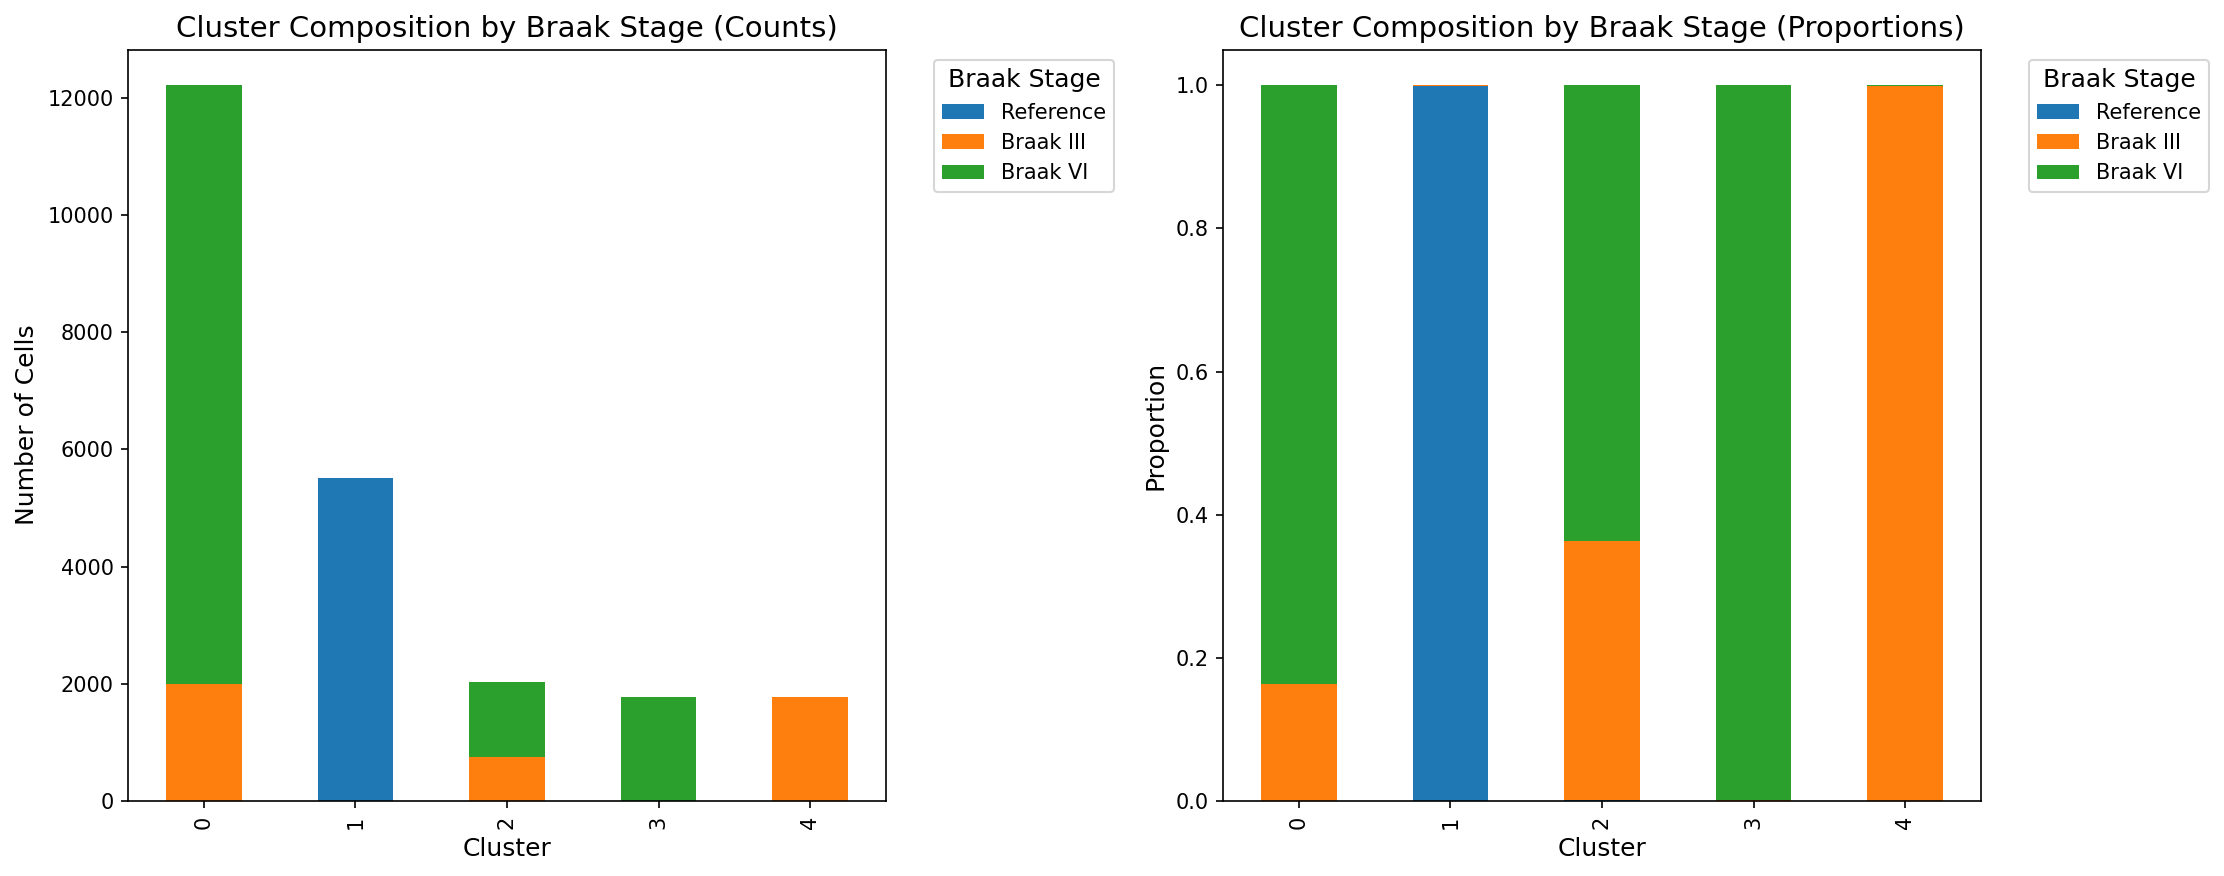


Chi-square test for cluster composition differences:
Chi-square statistic: 31662.1552
P-value: 0.0000e+00
Degrees of freedom: 8
Significant difference in cluster composition between Braak stages (p < 0.05)

Creating UMAP plot colored by Braak stage...


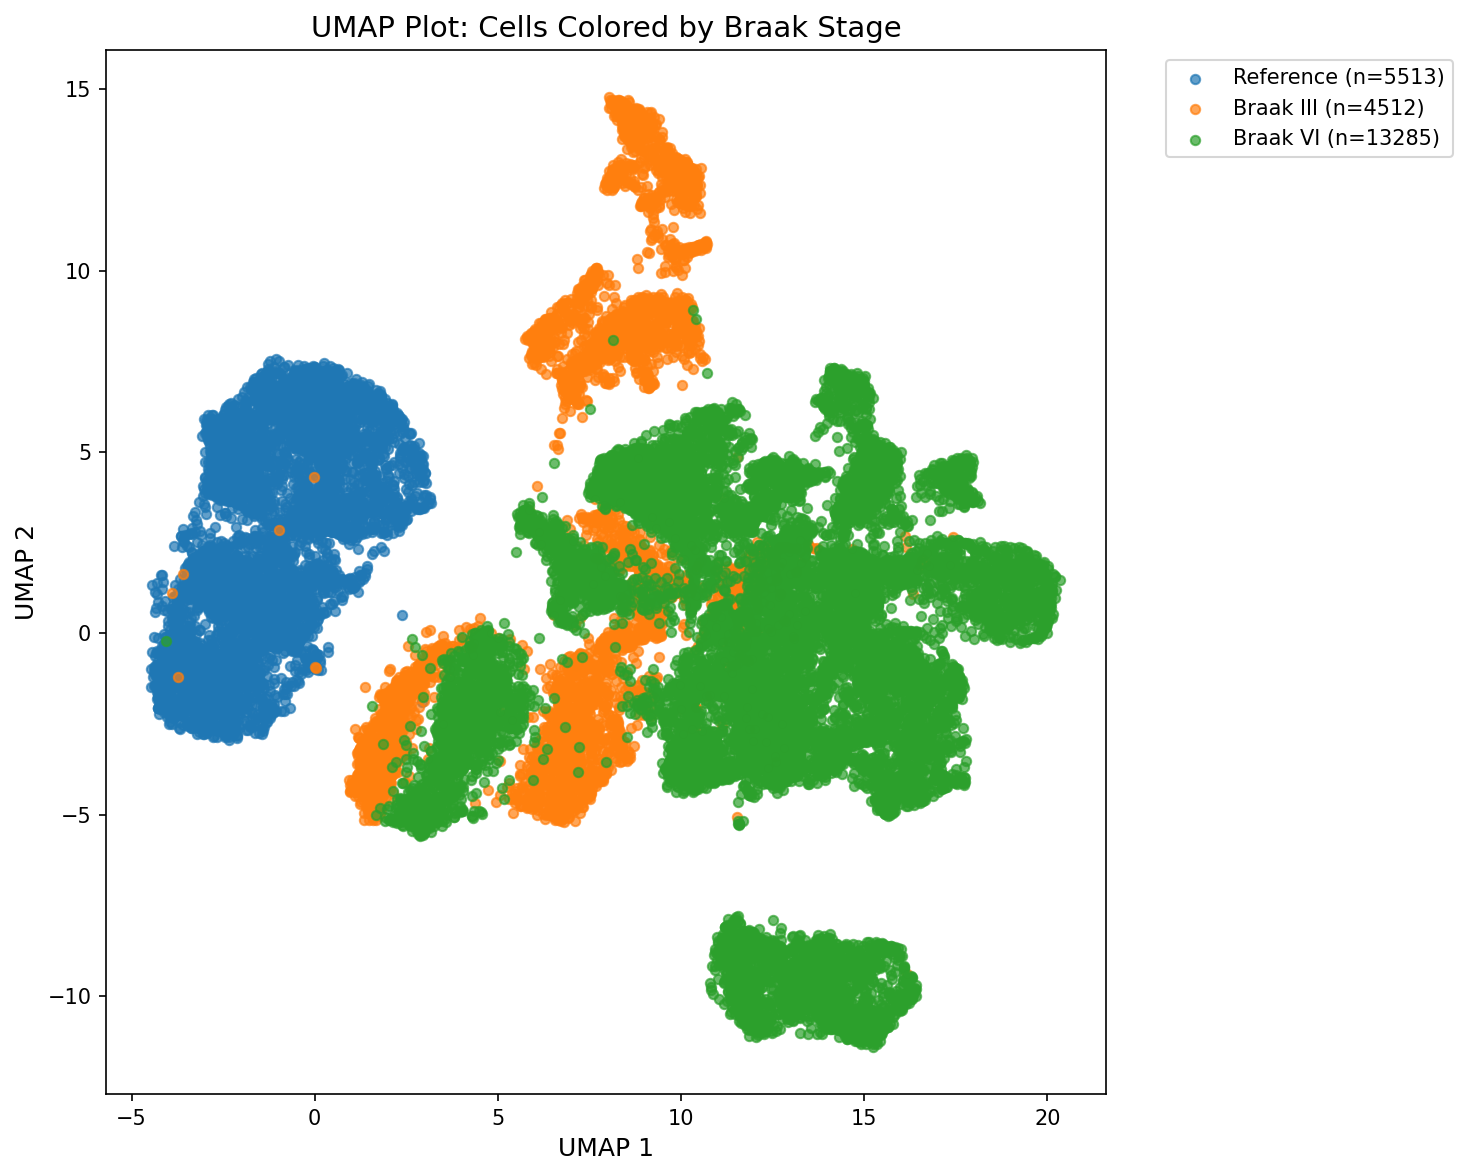

UMAP plot created successfully!


In [ ]:
# Analyze cluster composition by Braak stage
print("Analyzing cluster composition by Braak stage...")

if braak_col and 'leiden' in adata.obs.columns:
    # Create a cross-tabulation
    cluster_braak_crosstab = pd.crosstab(adata.obs['leiden'], adata.obs[braak_col])
    print("\nCluster composition by Braak stage:")
    print(cluster_braak_crosstab)
    
    # Calculate proportions
    cluster_braak_prop = pd.crosstab(adata.obs['leiden'], adata.obs[braak_col], normalize='index')
    print("\nCluster composition by Braak stage (proportions):")
    print(cluster_braak_prop)
    
    # Visualize cluster composition
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))
    
    # Absolute counts
    cluster_braak_crosstab.plot(kind='bar', ax=axes[0], stacked=True)
    axes[0].set_title('Cluster Composition by Braak Stage (Counts)')
    axes[0].set_xlabel('Cluster')
    axes[0].set_ylabel('Number of Cells')
    axes[0].legend(title='Braak Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Proportions
    cluster_braak_prop.plot(kind='bar', ax=axes[1], stacked=True)
    axes[1].set_title('Cluster Composition by Braak Stage (Proportions)')
    axes[1].set_xlabel('Cluster')
    axes[1].set_ylabel('Proportion')
    axes[1].legend(title='Braak Stage', bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()
    
    # Statistical test for cluster composition differences
    from scipy.stats import chi2_contingency
    
    chi2, p_value, dof, expected = chi2_contingency(cluster_braak_crosstab)
    print(f"\nChi-square test for cluster composition differences:")
    print(f"Chi-square statistic: {chi2:.4f}")
    print(f"P-value: {p_value:.4e}")
    print(f"Degrees of freedom: {dof}")
    
    if p_value < 0.05:
        print("Significant difference in cluster composition between Braak stages (p < 0.05)")
    else:
        print("No significant difference in cluster composition between Braak stages (p >= 0.05)")

else:
    print("Cannot analyze cluster composition - missing Braak stage or cluster information")

# Create UMAP plot colored by Braak stage
print("\nCreating UMAP plot colored by Braak stage...")
if braak_col and 'X_umap' in adata.obsm:
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Create color palette for Braak stages (5 distinct colors)
    braak_stages = adata.obs[braak_col].cat.categories
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']  # Blue, Orange, Green, Red, Purple
    
    for i, stage in enumerate(braak_stages):
        mask = adata.obs[braak_col] == stage
        ax.scatter(adata.obsm['X_umap'][mask, 0], 
                  adata.obsm['X_umap'][mask, 1], 
                  c=colors[i % len(colors)], 
                  label=f'{stage} (n={(mask).sum()})', 
                  alpha=0.7, s=20)
    
    ax.set_xlabel('UMAP 1')
    ax.set_ylabel('UMAP 2')
    ax.set_title('UMAP Plot: Cells Colored by Braak Stage')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    print("UMAP plot created successfully!")
else:
    print("Cannot create UMAP plot - missing UMAP coordinates or Braak stage information")


## Differential Gene Expression Analysis

Perform differential gene expression analysis between Braak stages using gene symbols.


## Pooled Single-cell Differential Gene Expression Analysis

Perform single-cell DGE with pooled control group (Reference + Braak 0 + Braak II) to match the pseudo-bulk pooling strategy and provide better statistical power at the cell level.


In [ ]:
# Perform single-cell DGE with pooled control group
print("="*80)
print("POOLED SINGLE-CELL DGE ANALYSIS")
print("="*80)
print("Pooling Reference + Braak 0 + Braak II as 'Control' for better statistical power")
print("="*80 + "\n")

# Create pooled control group
adata_sc_pooled = adata.copy()
adata_sc_pooled.obs['condition_pooled'] = adata_sc_pooled.obs[braak_col].astype(str)
adata_sc_pooled.obs.loc[
    adata_sc_pooled.obs[braak_col].isin(['Reference', 'Braak 0', 'Braak II']), 
    'condition_pooled'
] = 'Control'

# Show pooled grouping
print("Pooled grouping cell counts:")
print(adata_sc_pooled.obs.groupby('condition_pooled').size())
print("\nPooled grouping donor counts:")
print(adata_sc_pooled.obs.groupby('condition_pooled')['donor_id'].nunique())
print()

# Set gene symbols as index
adata_sc_pooled_dge = adata_sc_pooled.copy()
adata_sc_pooled_dge.var_names = adata_sc_pooled_dge.var['feature_name'].values

# Store pooled results
dge_results_pooled = {}

# Comparison 1: Control vs Braak III
print("-"*80)
print("Comparison 1: Control vs Braak III")
print("-"*80)

temp_adata = adata_sc_pooled_dge.copy()
temp_adata.X = adata_sc_pooled_dge.layers['log_normalized']
sc.tl.rank_genes_groups(temp_adata, 'condition_pooled', groups=['Braak III'], reference='Control', 
                       method='wilcoxon', use_raw=False)
dge_results_pooled['Control_vs_Braak_III'] = temp_adata.uns['rank_genes_groups'].copy()

print(f"Completed: Control vs Braak III")

# Comparison 2: Control vs Braak VI
print("\n" + "-"*80)
print("Comparison 2: Control vs Braak VI")
print("-"*80)

temp_adata = adata_sc_pooled_dge.copy()
temp_adata.X = adata_sc_pooled_dge.layers['log_normalized']
sc.tl.rank_genes_groups(temp_adata, 'condition_pooled', groups=['Braak VI'], reference='Control', 
                       method='wilcoxon', use_raw=False)
dge_results_pooled['Control_vs_Braak_VI'] = temp_adata.uns['rank_genes_groups'].copy()

print(f"Completed: Control vs Braak VI")

# Comparison 3: Braak III vs Braak VI (same as standard, for consistency)
print("\n" + "-"*80)
print("Comparison 3: Braak III vs Braak VI")
print("-"*80)

temp_adata = adata_sc_pooled_dge.copy()
temp_adata.X = adata_sc_pooled_dge.layers['log_normalized']
sc.tl.rank_genes_groups(temp_adata, 'condition_pooled', groups=['Braak VI'], reference='Braak III', 
                       method='wilcoxon', use_raw=False)
dge_results_pooled['Braak_III_vs_Braak_VI'] = temp_adata.uns['rank_genes_groups'].copy()

print(f"Completed: Braak III vs Braak VI")

# Store pooled results
adata.uns['dge_results_pooled'] = dge_results_pooled

print("\n" + "="*80)
print(f"Completed {len(dge_results_pooled)} pooled single-cell comparisons")
print("="*80)


In [ ]:
# Perform differential gene expression analysis
print("Performing differential gene expression analysis...")

# Check if we have the necessary information
if braak_col and adata.raw is not None:
    print(f"Using Braak stage column: {braak_col}")
    print(f"Available Braak stages: {adata.obs[braak_col].unique()}")
    
    # Get unique Braak stages
    unique_braak_stages = adata.obs[braak_col].unique()
    
    # Perform pairwise comparisons
    comparisons = []
    
    # Find Reference and Braak III/VI for comparison (exact matching)
    ref_stage = None
    braak3_stage = None
    braak6_stage = None
    
    for stage in unique_braak_stages:
        stage_str = str(stage)
        if stage_str == "Reference":
            ref_stage = stage
        elif stage_str == "Braak III":
            braak3_stage = stage
        elif stage_str == "Braak VI":
            braak6_stage = stage
    
    print(f"Reference stage: {ref_stage}")
    print(f"Braak III stage: {braak3_stage}")
    print(f"Braak VI stage: {braak6_stage}")
    
    # Set gene symbols as the index for better readability in results
    print(f"\nSetting gene symbols as index for DGE results...")
    # Create a copy with gene symbols as index
    adata_dge = adata.copy()
    adata_dge.var_names = adata_dge.var['feature_name'].values
    
    # Perform comparisons using log-transformed data (not raw counts)
    # Store results for each comparison separately
    dge_results = {}
    
    if ref_stage and braak3_stage:
        print(f"\nComparing {ref_stage} vs {braak3_stage}")
        temp_adata = adata_dge.copy()
        temp_adata.X = adata_dge.layers['log_normalized']  # Use log-transformed data
        sc.tl.rank_genes_groups(temp_adata, braak_col, groups=[braak3_stage], reference=ref_stage, 
                               method='wilcoxon', use_raw=False)  # Use log-transformed data
        dge_results[f"{ref_stage}_vs_{braak3_stage}"] = temp_adata.uns['rank_genes_groups'].copy()
        comparisons.append(f"{ref_stage}_vs_{braak3_stage}")
    
    if braak3_stage and braak6_stage:
        print(f"\nComparing {braak3_stage} vs {braak6_stage}")
        temp_adata = adata_dge.copy()
        temp_adata.X = adata_dge.layers['log_normalized']  # Use log-transformed data
        sc.tl.rank_genes_groups(temp_adata, braak_col, groups=[braak6_stage], reference=braak3_stage, 
                               method='wilcoxon', use_raw=False)  # Use log-transformed data
        dge_results[f"{braak3_stage}_vs_{braak6_stage}"] = temp_adata.uns['rank_genes_groups'].copy()
        comparisons.append(f"{braak3_stage}_vs_{braak6_stage}")
    
    # Store all DGE results in the main adata object
    adata.uns['dge_results'] = dge_results
    # Keep the last comparison in rank_genes_groups for volcano plots
    if dge_results:
        adata.uns['rank_genes_groups'] = list(dge_results.values())[-1]
    
    print(f"Completed {len(comparisons)} comparisons")
    
    # Show cell counts for each stage to verify we have enough cells
    print(f"\nCell counts per Braak stage:")
    for stage in unique_braak_stages:
        count = (adata.obs[braak_col] == stage).sum()
        print(f"  {stage}: {count} cells")
    
else:
    print("Cannot perform DEG analysis - missing Braak stage information or raw data")
    print(f"Braak column: {braak_col}")
    print(f"Raw data available: {adata.raw is not None}")


Performing differential gene expression analysis...
Using Braak stage column: Braak stage
Available Braak stages: ['Braak III', 'Braak VI', 'Reference']
Categories (3, object): ['Reference', 'Braak III', 'Braak VI']
Reference stage: Reference
Braak III stage: Braak III
Braak VI stage: Braak VI

Setting gene symbols as index for DGE results...

Comparing Reference vs Braak III
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:55)

Comparing Braak III vs Braak VI
ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges'

In [ ]:
# Define volcano plot function for differential gene expression results
def create_volcano_plot(adata, comparison_name, group_name, reference_name, pval_thresh=0.05, logfc_thresh=0.5):
    """Create a volcano plot for differential gene expression results with clear direction labels"""
    
    # Get the results
    result = adata.uns['rank_genes_groups']
    groups = result['names'].dtype.names
    
    if len(groups) == 0:
        print(f"No groups found for comparison {comparison_name}")
        return
    
    # Get the first group (should be the comparison group)
    group = groups[0]
    
    # Extract data
    names = result['names'][group]
    logfoldchanges = result['logfoldchanges'][group]
    pvals = result['pvals'][group]
    pvals_adj = result['pvals_adj'][group]
    
    # Create DataFrame
    df = pd.DataFrame({
        'gene': names,
        'logfc': logfoldchanges,
        'pval': pvals,
        'pval_adj': pvals_adj
    })
    
    # Remove NaN values
    df = df.dropna()
    
    # Calculate -log10(p-value)
    df['neg_log10_pval'] = -np.log10(df['pval'])
    
    # Define significance
    df['significant'] = (df['pval_adj'] < pval_thresh) & (np.abs(df['logfc']) > logfc_thresh)
    df['upregulated'] = df['significant'] & (df['logfc'] > 0)
    df['downregulated'] = df['significant'] & (df['logfc'] < 0)
    
    # Create volcano plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot non-significant genes
    ax.scatter(df[~df['significant']]['logfc'], 
               df[~df['significant']]['neg_log10_pval'], 
               c='gray', alpha=0.5, s=20, label='Not significant')
    
    # Plot upregulated genes (higher in comparison group)
    if df['upregulated'].sum() > 0:
        ax.scatter(df[df['upregulated']]['logfc'], 
                   df[df['upregulated']]['neg_log10_pval'], 
                   c='red', alpha=0.7, s=30, label=f'Higher in {group_name} (n={df["upregulated"].sum()})')
    
    # Plot downregulated genes (higher in reference group)
    if df['downregulated'].sum() > 0:
        ax.scatter(df[df['downregulated']]['logfc'], 
                   df[df['downregulated']]['neg_log10_pval'], 
                   c='blue', alpha=0.7, s=30, label=f'Higher in {reference_name} (n={df["downregulated"].sum()})')
    
    # Add threshold lines
    ax.axhline(y=-np.log10(pval_thresh), color='black', linestyle='--', alpha=0.5, label=f'p-value = {pval_thresh}')
    ax.axvline(x=logfc_thresh, color='black', linestyle='--', alpha=0.5, label=f'logFC = ±{logfc_thresh}')
    ax.axvline(x=-logfc_thresh, color='black', linestyle='--', alpha=0.5)
    
    # Labels and title with clear comparison
    ax.set_xlabel('Log2 Fold Change')
    ax.set_ylabel('-Log10 P-value')
    ax.set_title(f'{comparison_name}\nRed: Higher in {group_name} | Blue: Higher in {reference_name}')
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add gene labels for top genes (should now be gene symbols)
    top_genes = df.nlargest(5, 'neg_log10_pval')
    for _, row in top_genes.iterrows():
        ax.annotate(row['gene'], (row['logfc'], row['neg_log10_pval']), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print(f"\nSummary for {comparison_name}:")
    print(f"Total genes tested: {len(df)}")
    print(f"Higher in {group_name}: {df['upregulated'].sum()}")
    print(f"Higher in {reference_name}: {df['downregulated'].sum()}")
    print(f"Top 5 genes higher in {group_name}:")
    top_up = df[df['upregulated']].nlargest(5, 'logfc')
    for _, row in top_up.iterrows():
        print(f"  {row['gene']}: logFC={row['logfc']:.3f}, p-val={row['pval']:.2e}")
    
    print(f"Top 5 genes higher in {reference_name}:")
    top_down = df[df['downregulated']].nsmallest(5, 'logfc')
    for _, row in top_down.iterrows():
        print(f"  {row['gene']}: logFC={row['logfc']:.3f}, p-val={row['pval']:.2e}")
    
    return df

print("Volcano plot function defined successfully!")


## Volcano Plot Visualization

Create volcano plots to visualize the differential gene expression results with gene symbols.


In [ ]:
# Create volcano plots for pooled single-cell comparisons
if 'dge_results_pooled' in adata.uns:
    print("\n" + "="*80)
    print("Creating volcano plots for POOLED single-cell analysis...")
    print("="*80)
    
    # Create plots for each pooled comparison
    volcano_results_pooled = {}
    
    # Get all pooled comparison results
    dge_results_pooled_dict = adata.uns['dge_results_pooled']
    
    print(f"Found {len(dge_results_pooled_dict)} pooled comparison(s) in results\n")
    
    for comparison_key, result in dge_results_pooled_dict.items():
        groups = result['names'].dtype.names
        
        for group in groups:
            # Create clear comparison names
            if "Control_vs_Braak III" in comparison_key:
                comparison_name = "Control vs Braak III (Pooled SC)"
                group_name = "Braak III"
                reference_name = "Control"
            elif "Control_vs_Braak VI" in comparison_key:
                comparison_name = "Control vs Braak VI (Pooled SC)"
                group_name = "Braak VI"
                reference_name = "Control"
            elif "Braak_III_vs_Braak_VI" in comparison_key:
                comparison_name = "Braak III vs Braak VI (Pooled SC)"
                group_name = "Braak VI"
                reference_name = "Braak III"
            else:
                comparison_name = comparison_key
                group_name = str(group)
                reference_name = "Control"
            
            print(f"Creating volcano plot for: {comparison_name}")
            
            # Create a temporary adata with just this comparison
            temp_adata = adata.copy()
            temp_result = {
                'names': result['names'][[group]],
                'logfoldchanges': result['logfoldchanges'][[group]],
                'pvals': result['pvals'][[group]],
                'pvals_adj': result['pvals_adj'][[group]]
            }
            temp_adata.uns['rank_genes_groups'] = temp_result
            
            volcano_df = create_volcano_plot(temp_adata, comparison_name, group_name, reference_name)
            volcano_results_pooled[comparison_name] = volcano_df
    
    print("\n" + "="*80)
    print(f"Completed {len(volcano_results_pooled)} pooled single-cell volcano plots")
    print("="*80)
        
else:
    print("No pooled single-cell results found for volcano plots")


Creating volcano plots...
Found 2 comparison(s) in results

Creating volcano plot for: Reference vs Braak III


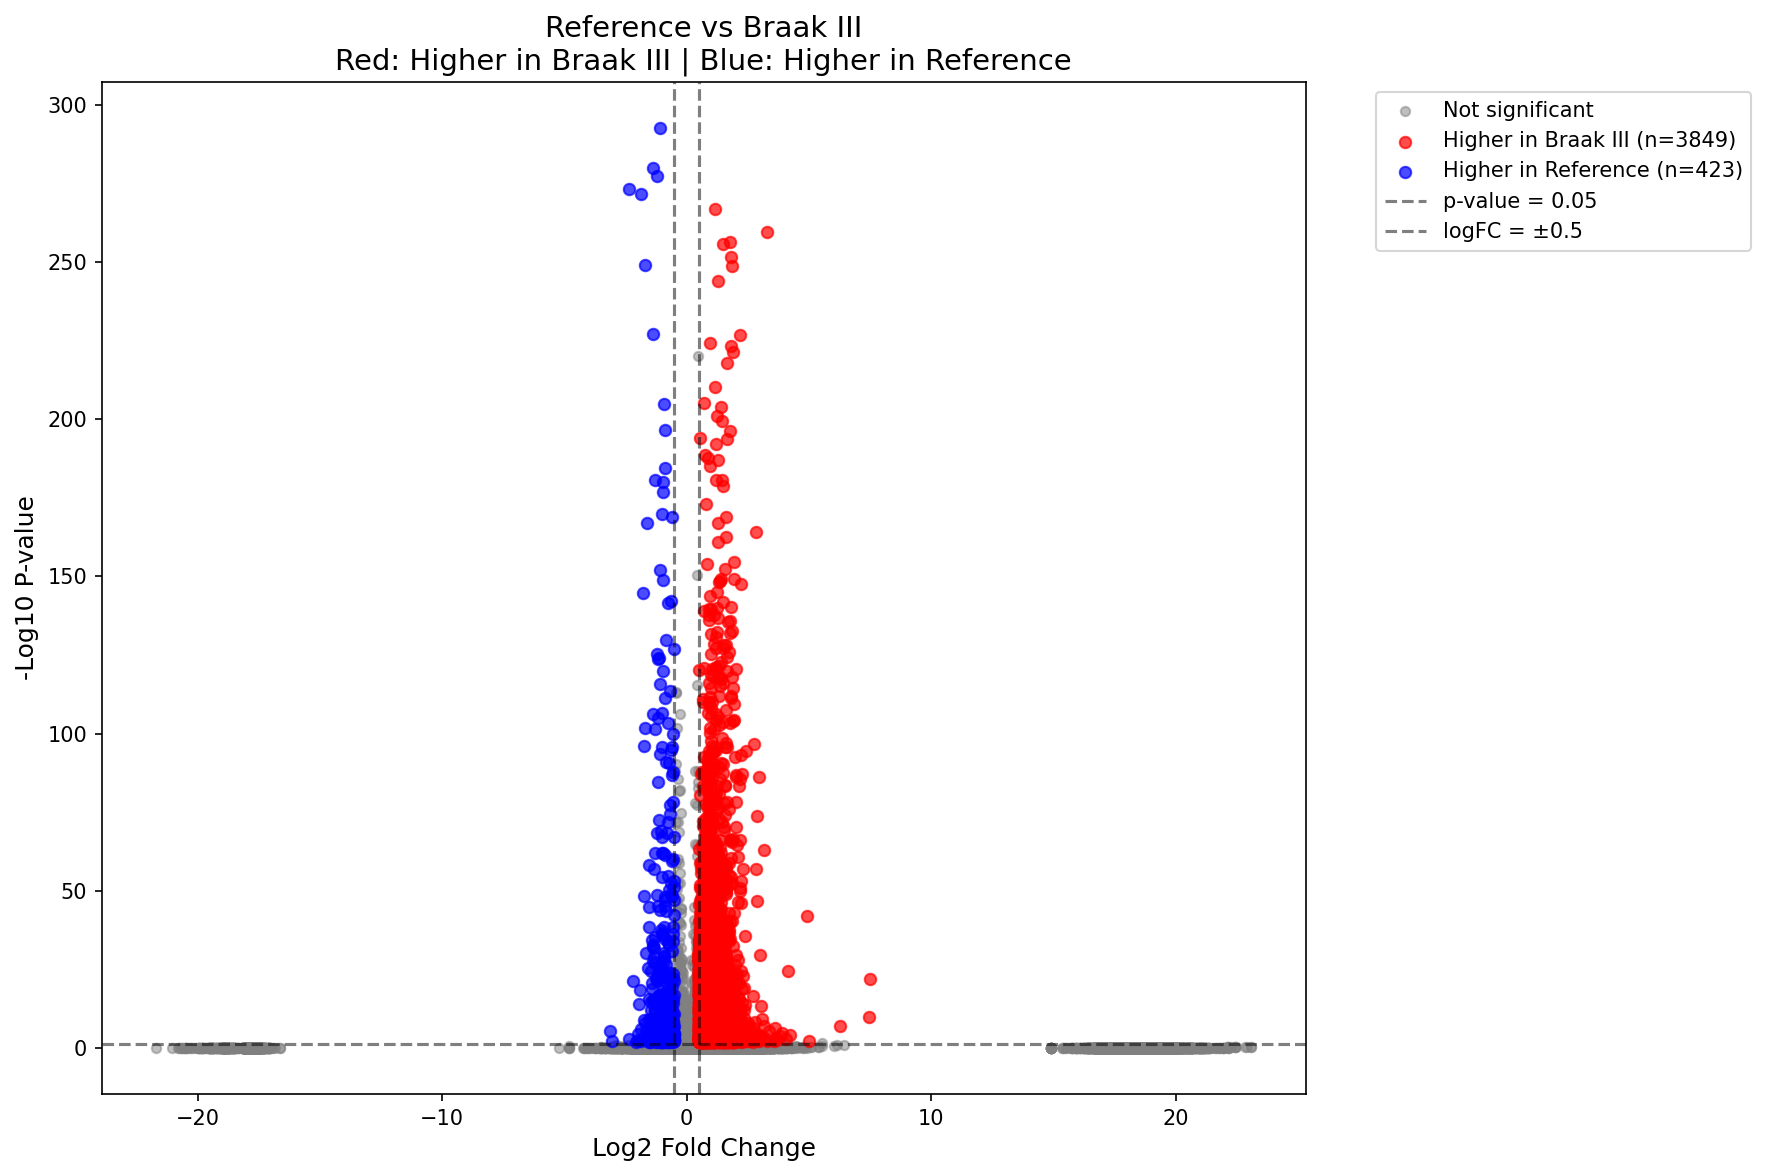


Summary for Reference vs Braak III:
Total genes tested: 36412
Higher in Braak III: 3849
Higher in Reference: 423
Top 5 genes higher in Braak III:
  XIST: logFC=10.079, p-val=0.00e+00
  TSIX: logFC=7.487, p-val=9.51e-23
  ENSG00000222031: logFC=7.436, p-val=1.64e-10
  ENSG00000270066: logFC=6.274, p-val=8.03e-08
  PLCG2: logFC=5.876, p-val=0.00e+00
Top 5 genes higher in Reference:
  LINC02899: logFC=-3.120, p-val=4.12e-06
  SST: logFC=-3.038, p-val=4.93e-03
  HOXD1: logFC=-2.377, p-val=1.40e-03
  HEPN1: logFC=-2.353, p-val=8.57e-274
  ENSG00000249061: logFC=-2.204, p-val=4.50e-22

Creating volcano plot for: Braak III vs Braak VI


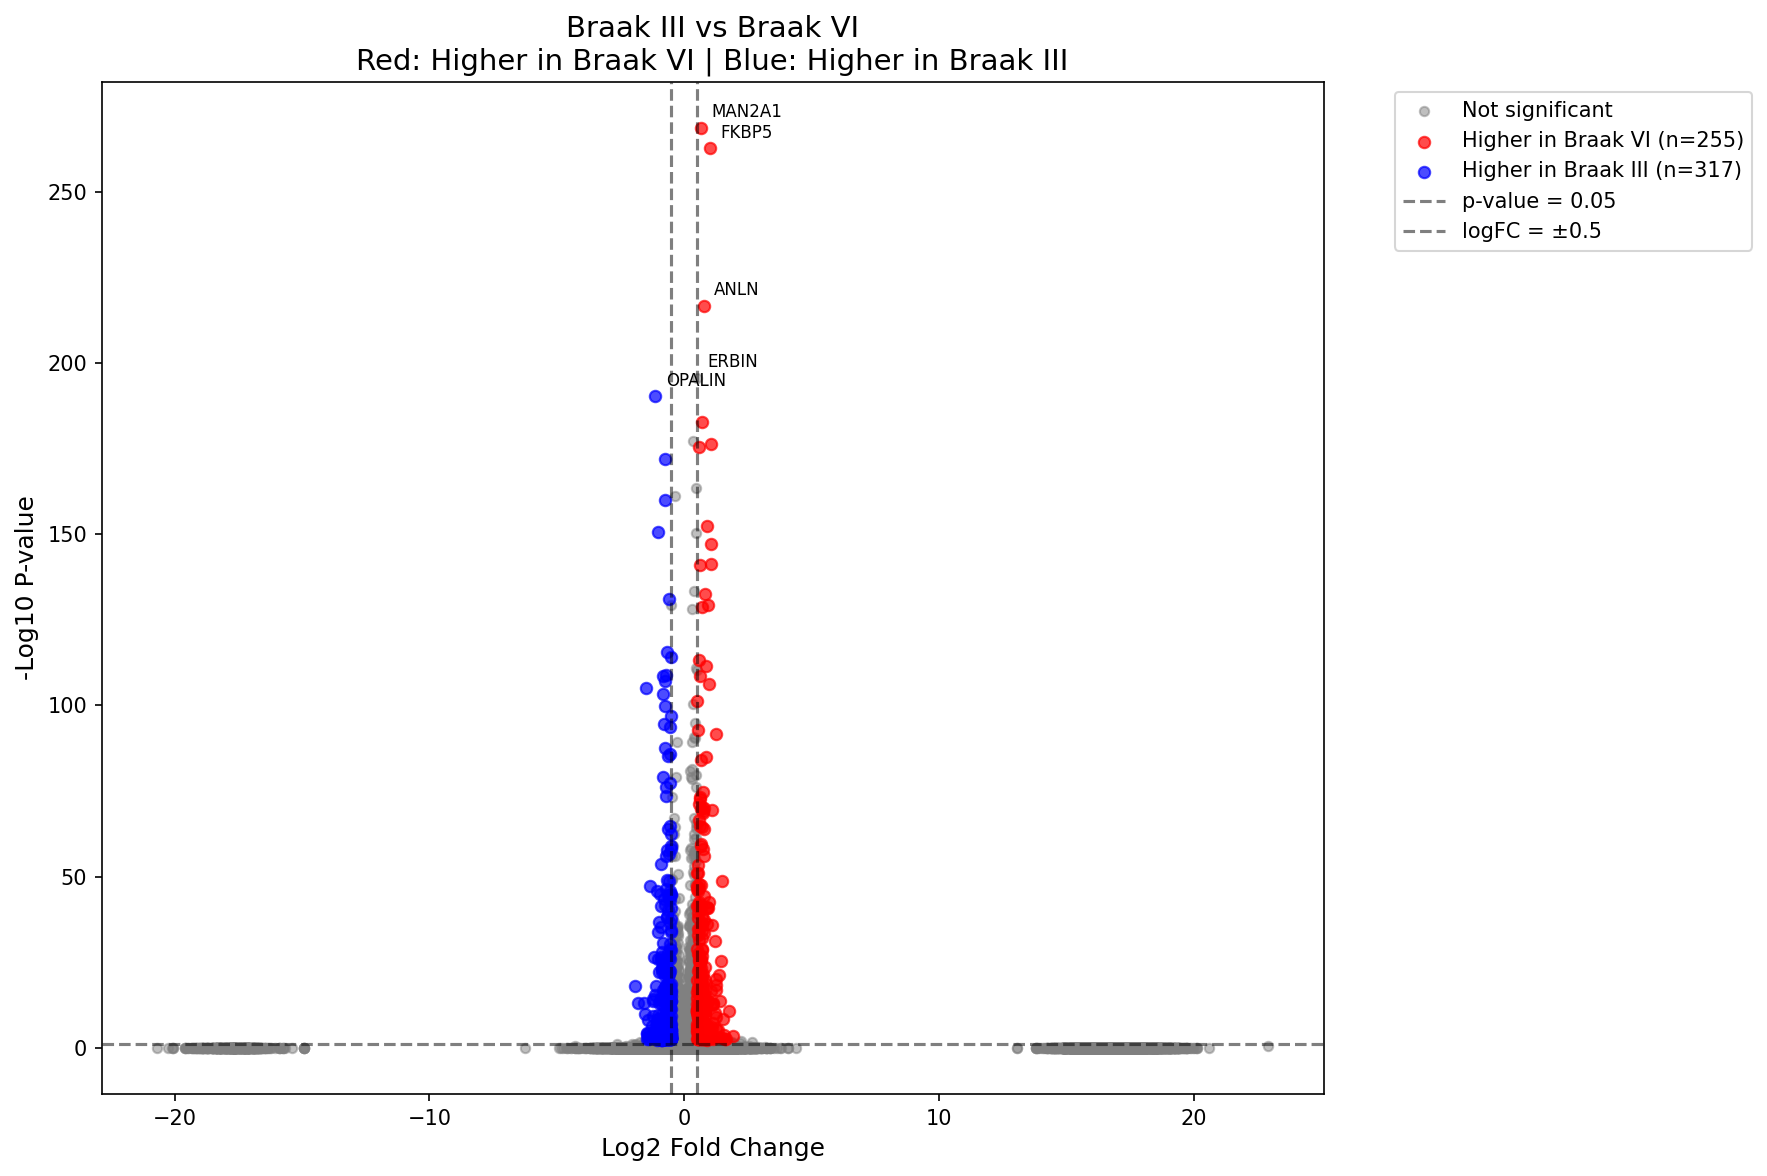


Summary for Braak III vs Braak VI:
Total genes tested: 36412
Higher in Braak VI: 255
Higher in Braak III: 317
Top 5 genes higher in Braak VI:
  CFAP61: logFC=1.907, p-val=3.01e-04
  TPD52L1: logFC=1.762, p-val=1.83e-11
  MYRFL: logFC=1.658, p-val=2.31e-03
  LPL: logFC=1.601, p-val=2.07e-03
  ADARB2-AS1: logFC=1.577, p-val=1.92e-04
Top 5 genes higher in Braak III:
  HLA-DMA: logFC=-1.923, p-val=1.06e-18
  KIF5C-AS1: logFC=-1.832, p-val=5.51e-14
  LINC02197: logFC=-1.563, p-val=8.90e-14
  LINC00279: logFC=-1.544, p-val=1.23e-10
  ROR1: logFC=-1.507, p-val=1.04e-105


In [ ]:
# Create volcano plots for standard single-cell comparisons
if 'dge_results' in adata.uns:
    print("Creating volcano plots...")
    
    # Create plots for each comparison with clear labels
    volcano_results = {}
    
    # Get all comparison results
    dge_results = adata.uns['dge_results']
    
    print(f"Found {len(dge_results)} comparison(s) in results")
    
    for comparison_key, result in dge_results.items():
        groups = result['names'].dtype.names
        
        for group in groups:
            # Create clear comparison names and determine reference
            if "Reference_vs_Braak III" in comparison_key:
                comparison_name = "Reference vs Braak III"
                group_name = "Braak III"
                reference_name = "Reference"
            elif "Braak III_vs_Braak VI" in comparison_key:
                comparison_name = "Braak III vs Braak VI"
                group_name = "Braak VI"
                reference_name = "Braak III"
            else:
                comparison_name = comparison_key
                group_name = str(group)
                reference_name = "Reference"
            
            print(f"\nCreating volcano plot for: {comparison_name}")
            
            # Create a temporary adata with just this comparison
            temp_adata = adata.copy()
            temp_result = {
                'names': result['names'][[group]],
                'logfoldchanges': result['logfoldchanges'][[group]],
                'pvals': result['pvals'][[group]],
                'pvals_adj': result['pvals_adj'][[group]]
            }
            temp_adata.uns['rank_genes_groups'] = temp_result
            
            volcano_df = create_volcano_plot(temp_adata, comparison_name, group_name, reference_name)
            volcano_results[comparison_name] = volcano_df
        
else:
    print("No differential gene expression results found for volcano plots")


## Pseudo-bulk Differential Gene Expression Analysis

Perform pseudo-bulk differential gene expression analysis by aggregating counts across donors/samples within each Braak stage. This approach increases statistical power and reduces noise compared to single-cell methods.


In [ ]:
# Pseudo-bulk aggregation and DESeq2 differential expression analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings

# Try to import pyDESeq2
try:
    from pydeseq2.dds import DeseqDataSet
    from pydeseq2.ds import DeseqStats
    PYDESEQ2_AVAILABLE = True
    print("✓ pyDESeq2 is available and will be used")
except ImportError:
    PYDESEQ2_AVAILABLE = False
    print("⚠️  WARNING: pyDESeq2 not installed!")
    print("   Install with: pip install pydeseq2")
    print("   Cannot proceed with DESeq2 analysis.")

def aggregate_pseudobulk(adata, group_col, sample_col='donor_id'):
    """
    Aggregate single-cell counts to pseudo-bulk samples
    
    Parameters:
    -----------
    adata : AnnData
        AnnData object with raw counts
    group_col : str
        Column name for grouping (e.g., 'Braak stage')
    sample_col : str
        Column name for sample/donor identifier
    
    Returns:
    --------
    pseudobulk_df : DataFrame
        Pseudo-bulk count matrix (genes x samples)
    sample_metadata : DataFrame
        Metadata for each pseudo-bulk sample
    """
    
    print(f"Aggregating counts by {sample_col} within each {group_col}...")
    
    # Get raw counts from the original unfiltered data
    # Use the raw attribute which contains all genes
    if adata.raw is not None:
        counts_matrix = adata.raw.X
        gene_names = adata.raw.var['feature_name'].values
    else:
        counts_matrix = adata.X
        gene_names = adata.var['feature_name'].values
    
    # Convert to dense if sparse
    if hasattr(counts_matrix, 'toarray'):
        counts_matrix = counts_matrix.toarray()
    
    # Create DataFrame with counts
    counts_df = pd.DataFrame(
        counts_matrix,
        columns=gene_names,
        index=adata.obs.index
    )
    
    # Add metadata
    counts_df[group_col] = adata.obs[group_col].values
    counts_df[sample_col] = adata.obs[sample_col].values
    
    # Aggregate by sample within each group
    pseudobulk_list = []
    metadata_list = []
    
    for group in sorted(adata.obs[group_col].unique()):
        group_data = counts_df[counts_df[group_col] == group]
        
        for sample in sorted(group_data[sample_col].unique()):
            sample_data = group_data[group_data[sample_col] == sample]
            
            # Sum counts across cells
            sample_counts = sample_data.drop([group_col, sample_col], axis=1).sum(axis=0)
            
            # Convert to list to avoid issues with duplicate gene names
            pseudobulk_list.append(sample_counts.values)
            metadata_list.append({
                'sample_id': f"{group}_{sample}",
                'donor_id': sample,
                'condition': str(group),
                'n_cells': len(sample_data)
            })
    
    # Create pseudo-bulk count matrix (genes x samples for DESeq2)
    pseudobulk_counts = pd.DataFrame(pseudobulk_list, columns=gene_names).T  # Transpose so genes are rows
    metadata_df = pd.DataFrame(metadata_list)
    metadata_df.index = metadata_df['sample_id']
    pseudobulk_counts.columns = metadata_df['sample_id']
    
    print(f"Created {len(metadata_df)} pseudo-bulk samples")
    print(f"Samples per condition:")
    print(metadata_df.groupby('condition').size())
    
    return pseudobulk_counts, metadata_df


def run_deseq2_analysis(counts_df, metadata_df, ref_level, test_level):
    """
    Run DESeq2 differential expression analysis
    
    Parameters:
    -----------
    counts_df : DataFrame
        Count matrix (genes x samples)
    metadata_df : DataFrame
        Sample metadata with 'condition' column
    ref_level : str
        Reference condition level
    test_level : str
        Test condition level
    
    Returns:
    --------
    results_df : DataFrame
        DESeq2 results with log2FC, p-values, etc.
    """
    
    if not PYDESEQ2_AVAILABLE:
        raise ImportError("pyDESeq2 is not installed. Cannot run analysis.")
    
    print(f"\nRunning DESeq2: {ref_level} vs {test_level}")
    
    # Filter to only include the two conditions
    samples_to_keep = metadata_df[metadata_df['condition'].isin([ref_level, test_level])].index
    counts_subset = counts_df[samples_to_keep]
    metadata_subset = metadata_df.loc[samples_to_keep].copy()
    
    print(f"  {ref_level}: {(metadata_subset['condition'] == ref_level).sum()} samples")
    print(f"  {test_level}: {(metadata_subset['condition'] == test_level).sum()} samples")
    
    # Filter out genes with very low counts
    min_counts = 10
    min_samples = 3
    keep_genes = (counts_subset >= min_counts).sum(axis=1) >= min_samples
    counts_filtered = counts_subset[keep_genes]
    
    print(f"  Filtered to {len(counts_filtered)} genes (≥{min_counts} counts in ≥{min_samples} samples)")
    
    # Validate data before creating DeseqDataSet
    print(f"  Data validation:")
    print(f"    - Count matrix shape: {counts_filtered.shape}")
    print(f"    - Metadata shape: {metadata_subset.shape}")
    print(f"    - Condition levels: {metadata_subset['condition'].unique()}")
    print(f"    - Reference level: {ref_level}")
    print(f"    - Test level: {test_level}")
    
    # Check for potential issues
    if counts_filtered.shape[0] < 100:
        print(f"  ⚠️  Warning: Only {counts_filtered.shape[0]} genes after filtering")
    if counts_filtered.shape[1] < 6:
        print(f"  ⚠️  Warning: Only {counts_filtered.shape[1]} samples")
    
    # Create DeseqDataSet
    # Note: DESeq2 expects samples as rows, genes as columns, so we need to transpose
    print("  Creating DeseqDataSet...")
    try:
        dds = DeseqDataSet(
            counts=counts_filtered.T.astype(int),  # Transpose: samples × genes
            metadata=metadata_subset,
            design_factors="condition",
            ref_level=["condition", ref_level],
            refit_cooks=True
        )
        print("  ✓ DeseqDataSet created successfully")
    except Exception as e:
        print(f"  ❌ Error creating DeseqDataSet: {e}")
        raise RuntimeError(f"Failed to create DeseqDataSet: {e}")
    
    # Run DESeq2 pipeline
    print("  Running DESeq2 pipeline...")
    deseq2_success = False
    try:
        # Check for potential issues before running deseq2
        print("    - Checking for duplicate sample names...")
        if len(set(metadata_subset.index)) != len(metadata_subset.index):
            print("    ⚠️  Warning: Duplicate sample names detected")
            print(f"    Sample names: {list(metadata_subset.index)}")
        
        print("    - Checking count matrix for issues...")
        if counts_filtered.T.shape[0] != len(metadata_subset):
            print(f"    ⚠️  Warning: Count matrix samples ({counts_filtered.T.shape[0]}) != metadata samples ({len(metadata_subset)})")
        
        dds.deseq2()
        deseq2_success = True
        print("  ✓ DESeq2 fitting completed successfully")
    except Exception as e:
        print(f"  ❌ Error during DESeq2 fitting: {e}")
        print("  Cannot proceed with statistical analysis")
        print(f"  Error type: {type(e).__name__}")
        raise RuntimeError(f"DESeq2 fitting failed: {e}")
    
    # Get statistical results (only if deseq2 succeeded)
    if deseq2_success:
        print("  Calculating statistics...")
        try:
            stat_res = DeseqStats(dds, contrast=["condition", test_level, ref_level])
            stat_res.summary()
        except Exception as e:
            print(f"  ❌ Error during statistical analysis: {e}")
            raise RuntimeError(f"DESeq2 statistical analysis failed: {e}")
    else:
        raise RuntimeError("Cannot run statistical analysis - DESeq2 fitting failed")
    
    # Get results
    results_df = stat_res.results_df.copy()
    results_df['gene_symbol'] = results_df.index
    
    # Rename columns for consistency
    results_df = results_df.rename(columns={
        'log2FoldChange': 'log2fc',
        'pvalue': 'pval',
        'padj': 'pval_adj',
        'baseMean': 'base_mean',
        'lfcSE': 'log2fc_se'
    })
    
    # Sort by p-value
    results_df = results_df.sort_values('pval')
    
    print(f"  Tested {len(results_df)} genes")
    print(f"  Significant (padj < 0.05): {(results_df['pval_adj'] < 0.05).sum()}")
    print(f"  Significant & |log2fc| > 0.5: {((results_df['pval_adj'] < 0.05) & (np.abs(results_df['log2fc']) > 0.5)).sum()}")
    
    return results_df


def plot_deseq2_volcano(results_df, comparison_name, pval_thresh=0.05, logfc_thresh=0.5):
    """
    Create volcano plot for DESeq2 results
    """
    
    # Handle NA values
    results_plot = results_df.dropna(subset=['pval', 'log2fc', 'pval_adj']).copy()
    
    # Calculate -log10(p-value)
    results_plot['neg_log10_pval'] = -np.log10(results_plot['pval'].clip(lower=1e-300))
    
    # Define significance
    results_plot['significant'] = (results_plot['pval_adj'] < pval_thresh) & (np.abs(results_plot['log2fc']) > logfc_thresh)
    results_plot['upregulated'] = results_plot['significant'] & (results_plot['log2fc'] > 0)
    results_plot['downregulated'] = results_plot['significant'] & (results_plot['log2fc'] < 0)
    
    # Create volcano plot
    fig, ax = plt.subplots(figsize=(12, 8))
    
    # Plot non-significant genes
    ax.scatter(results_plot[~results_plot['significant']]['log2fc'], 
               results_plot[~results_plot['significant']]['neg_log10_pval'], 
               c='gray', alpha=0.5, s=20, label='Not significant')
    
    # Plot upregulated genes
    n_up = results_plot['upregulated'].sum()
    if n_up > 0:
        ax.scatter(results_plot[results_plot['upregulated']]['log2fc'], 
                   results_plot[results_plot['upregulated']]['neg_log10_pval'], 
                   c='red', alpha=0.7, s=30, label=f'Upregulated (n={n_up})')
    
    # Plot downregulated genes
    n_down = results_plot['downregulated'].sum()
    if n_down > 0:
        ax.scatter(results_plot[results_plot['downregulated']]['log2fc'], 
                   results_plot[results_plot['downregulated']]['neg_log10_pval'], 
                   c='blue', alpha=0.7, s=30, label=f'Downregulated (n={n_down})')
    
    # Add threshold lines
    ax.axhline(y=-np.log10(pval_thresh), color='black', linestyle='--', alpha=0.5, label=f'padj = {pval_thresh}')
    ax.axvline(x=logfc_thresh, color='black', linestyle='--', alpha=0.5, label=f'log2FC = ±{logfc_thresh}')
    ax.axvline(x=-logfc_thresh, color='black', linestyle='--', alpha=0.5)
    
    # Labels and title
    ax.set_xlabel('Log2 Fold Change', fontsize=14)
    ax.set_ylabel('-Log10 P-value', fontsize=14)
    ax.set_title(f'DESeq2 Pseudo-bulk: {comparison_name}', fontsize=16)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Add gene labels for top significant genes
    top_genes = results_plot[results_plot['significant']].nlargest(10, 'neg_log10_pval')
    for _, row in top_genes.iterrows():
        ax.annotate(row['gene_symbol'], (row['log2fc'], row['neg_log10_pval']), 
                   xytext=(5, 5), textcoords='offset points', fontsize=8, alpha=0.8)
    
    plt.tight_layout()
    plt.show()
    
    # Print summary
    print(f"\nDESeq2 Summary for {comparison_name}:")
    print(f"Total genes tested: {len(results_plot)}")
    print(f"Upregulated (padj < {pval_thresh}, log2FC > {logfc_thresh}): {n_up}")
    print(f"Downregulated (padj < {pval_thresh}, log2FC < -{logfc_thresh}): {n_down}")
    
    if n_up > 0:
        print(f"\nTop 5 upregulated genes:")
        top_up = results_plot[results_plot['upregulated']].nlargest(5, 'log2fc')
        for _, row in top_up.iterrows():
            print(f"  {row['gene_symbol']}: log2FC={row['log2fc']:.3f}, padj={row['pval_adj']:.2e}")
    
    if n_down > 0:
        print(f"\nTop 5 downregulated genes:")
        top_down = results_plot[results_plot['downregulated']].nsmallest(5, 'log2fc')
        for _, row in top_down.iterrows():
            print(f"  {row['gene_symbol']}: log2FC={row['log2fc']:.3f}, padj={row['pval_adj']:.2e}")
    
    return fig


print("="*80)
print("DESeq2 pseudo-bulk functions defined successfully!")
print("="*80)


In [ ]:
# ============================================================================
# ANALYSIS 1: STANDARD GROUPING (Reference vs Braak III vs Braak VI)
# ============================================================================

print("\n" + "="*80)
print("ANALYSIS 1: STANDARD GROUPING (Filtered Data)")
print("="*80)
print("Using original groups: Reference (3 donors), Braak III (6 donors), Braak VI (13 donors)")
print("⚠️  Note: Reference group has minimum recommended donors")
print("="*80 + "\n")

# Aggregate current filtered data to pseudo-bulk
pseudobulk_counts, pseudobulk_metadata = aggregate_pseudobulk(adata, group_col=braak_col, sample_col='donor_id')

# Store results
deseq2_results_standard = {}

if PYDESEQ2_AVAILABLE:
    # Comparison 1: Reference vs Braak III
    if ref_stage and braak3_stage:
        print("\n" + "-"*80)
        print(f"Comparison 1: {ref_stage} vs {braak3_stage}")
        print("-"*80)
        
        try:
            deg_ref_vs_b3 = run_deseq2_analysis(
                pseudobulk_counts,
                pseudobulk_metadata,
                ref_level=str(ref_stage),
                test_level=str(braak3_stage)
            )
            deseq2_results_standard['Reference_vs_Braak_III'] = deg_ref_vs_b3
            plot_deseq2_volcano(deg_ref_vs_b3, f"{ref_stage} vs {braak3_stage}")
        except Exception as e:
            print(f"❌ Error in Reference vs Braak III: {e}")
    
    # Comparison 2: Braak III vs Braak VI
    if braak3_stage and braak6_stage:
        print("\n" + "-"*80)
        print(f"Comparison 2: {braak3_stage} vs {braak6_stage}")
        print("-"*80)
        
        try:
            deg_b3_vs_b6 = run_deseq2_analysis(
                pseudobulk_counts,
                pseudobulk_metadata,
                ref_level=str(braak3_stage),
                test_level=str(braak6_stage)
            )
            deseq2_results_standard['Braak_III_vs_Braak_VI'] = deg_b3_vs_b6
            plot_deseq2_volcano(deg_b3_vs_b6, f"{braak3_stage} vs {braak6_stage}")
        except Exception as e:
            print(f"❌ Error in Braak III vs Braak VI: {e}")
    
    print("\n" + "="*80)
    print(f"✓ Completed {len(deseq2_results_standard)} DESeq2 comparisons (standard grouping)")
    print("="*80)
else:
    print("❌ Cannot run DESeq2 - pydeseq2 not installed")


In [ ]:
# ============================================================================
# ANALYSIS 2: POOLED CONTROL (Reference + Braak 0 + Braak II)
# ============================================================================

print("\n\n" + "="*80)
print("ANALYSIS 2: POOLED CONTROL GROUPING")
print("="*80)
print("Pooling early-stage Braak stages into 'Control' group for better statistical power")
print("Control = Reference + Braak 0 + Braak II (9 donors)")
print("Braak III (6 donors), Braak VI (13 donors)")
print("="*80 + "\n")

# Create a modified adata with pooled control
adata_pooled = adata.copy()

# Create new column with pooled groups
# Pool Reference, Braak 0, and Braak II as "Control" (early/pre-clinical stages)
adata_pooled.obs['condition_pooled'] = adata_pooled.obs[braak_col].astype(str)
adata_pooled.obs.loc[adata_pooled.obs[braak_col].isin(['Reference', 'Braak 0', 'Braak II']), 'condition_pooled'] = 'Control'

# Show pooled grouping
print("Pooled grouping summary:")
print(adata_pooled.obs.groupby('condition_pooled')['donor_id'].nunique())
print()

# Aggregate to pseudo-bulk with pooled groups
pseudobulk_counts_pooled, pseudobulk_metadata_pooled = aggregate_pseudobulk(
    adata_pooled, 
    group_col='condition_pooled', 
    sample_col='donor_id'
)

# Store results
deseq2_results_pooled = {}

if PYDESEQ2_AVAILABLE:
    # Comparison 1: Control vs Braak III
    print("\n" + "-"*80)
    print("Comparison 1: Control vs Braak III")
    print("-"*80)
    
    try:
        deg_ctrl_vs_b3 = run_deseq2_analysis(
            pseudobulk_counts_pooled,
            pseudobulk_metadata_pooled,
            ref_level='Control',
            test_level='Braak III'
        )
        deseq2_results_pooled['Control_vs_Braak_III'] = deg_ctrl_vs_b3
        plot_deseq2_volcano(deg_ctrl_vs_b3, "Control vs Braak III (Pooled)")
    except Exception as e:
        print(f"❌ Error in Control vs Braak III: {e}")
    
    # Comparison 2: Control vs Braak VI
    print("\n" + "-"*80)
    print("Comparison 2: Control vs Braak VI")
    print("-"*80)
    
    try:
        deg_ctrl_vs_b6 = run_deseq2_analysis(
            pseudobulk_counts_pooled,
            pseudobulk_metadata_pooled,
            ref_level='Control',
            test_level='Braak VI'
        )
        deseq2_results_pooled['Control_vs_Braak_VI'] = deg_ctrl_vs_b6
        plot_deseq2_volcano(deg_ctrl_vs_b6, "Control vs Braak VI (Pooled)")
    except Exception as e:
        print(f"❌ Error in Control vs Braak VI: {e}")
    
    # Comparison 3: Braak III vs Braak VI (pooled dataset)
    print("\n" + "-"*80)
    print("Comparison 3: Braak III vs Braak VI")
    print("-"*80)
    
    try:
        deg_b3_vs_b6_pooled = run_deseq2_analysis(
            pseudobulk_counts_pooled,
            pseudobulk_metadata_pooled,
            ref_level='Braak III',
            test_level='Braak VI'
        )
        deseq2_results_pooled['Braak_III_vs_Braak_VI'] = deg_b3_vs_b6_pooled
        plot_deseq2_volcano(deg_b3_vs_b6_pooled, "Braak III vs Braak VI (Pooled)")
    except Exception as e:
        print(f"❌ Error in Braak III vs Braak VI: {e}")
    
    print("\n" + "="*80)
    print(f"✓ Completed {len(deseq2_results_pooled)} DESeq2 comparisons (pooled grouping)")
    print("="*80)
else:
    print("❌ Cannot run DESeq2 - pydeseq2 not installed")


# ============================================================================
# SUMMARY AND COMPARISON
# ============================================================================

print("\n\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

if PYDESEQ2_AVAILABLE and deseq2_results_standard and deseq2_results_pooled:
    print("\n📊 Standard Grouping Results:")
    for comparison, results in deseq2_results_standard.items():
        n_sig = ((results['pval_adj'] < 0.05) & (np.abs(results['log2fc']) > 0.5)).sum()
        print(f"   {comparison}: {n_sig} significant genes")
    
    print("\n📊 Pooled Control Results:")
    for comparison, results in deseq2_results_pooled.items():
        n_sig = ((results['pval_adj'] < 0.05) & (np.abs(results['log2fc']) > 0.5)).sum()
        print(f"   {comparison}: {n_sig} significant genes")
    
    print("\n💡 Interpretation Guide:")
    print("   - Standard grouping preserves biological distinctions but has limited power for Reference")
    print("   - Pooled control increases statistical power by combining early-stage groups:")
    print("     * Control = Reference + Braak 0 + Braak II (9 donors)")
    print("     * Assumes these are all pre-clinical/early pathology stages")
    print("   - Genes significant in BOTH analyses are most robust")
    print("   - For publications, consider reporting both and discussing the biological rationale")

print("="*80)


In [ ]:
# Pseudo-bulk aggregation and DESeq2 differential expression analysis
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
from scipy import sparse

# Try to import pyDESeq2
try:
    from pydeseq2.dds import DeseqDataSet
    from pydeseq2.ds import DeseqStats
    PYDESEQ2_AVAILABLE = True
    print("✓ pyDESeq2 is available and will be used")
except ImportError:
    PYDESEQ2_AVAILABLE = False
    print("⚠️  WARNING: pyDESeq2 not installed!")
    print("   Install with: pip install pydeseq2")
    print("   Cannot proceed with DESeq2 analysis.")

def _make_unique(ids):
    """Append suffixes to duplicate identifiers to make them unique."""
    seen = {}
    unique_ids = []
    for identifier in ids:
        identifier = str(identifier)
        if identifier in seen:
            seen[identifier] += 1
            unique_ids.append(f"{identifier}_{seen[identifier]}")
        else:
            seen[identifier] = 0
            unique_ids.append(identifier)
    return unique_ids

def aggregate_pseudobulk(adata, group_col, sample_col='donor_id'):
    """
    Aggregate single-cell counts to pseudo-bulk samples.

    Parameters
    ----------
    adata : AnnData
        AnnData object with raw counts
    group_col : str
        Column name for grouping (e.g., 'Braak stage')
    sample_col : str
        Column name for sample/donor identifier

    Returns
    -------
    pseudobulk_df : DataFrame
        Pseudo-bulk count matrix (genes x samples)
    sample_metadata : DataFrame
        Metadata for each pseudo-bulk sample
    gene_symbol_map : dict
        Mapping from gene identifiers to gene symbols
    """

    if group_col not in adata.obs.columns:
        raise KeyError(f"Column '{group_col}' not found in adata.obs")
    if sample_col not in adata.obs.columns:
        raise KeyError(f"Column '{sample_col}' not found in adata.obs")

    print(f"Aggregating counts by {sample_col} within each {group_col}...")

    if adata.raw is not None:
        var_df = adata.raw.var
        counts_matrix = adata.raw.X
        gene_ids = np.asarray(adata.raw.var_names, dtype=str)
        if 'feature_name' in var_df.columns:
            gene_symbols = var_df['feature_name'].astype(str).fillna('').values
        else:
            gene_symbols = gene_ids
    else:
        var_df = adata.var
        counts_matrix = adata.X
        gene_ids = np.asarray(adata.var_names, dtype=str)
        if 'feature_name' in var_df.columns:
            gene_symbols = var_df['feature_name'].astype(str).fillna('').values
        else:
            gene_symbols = gene_ids

    if not pd.Index(gene_ids).is_unique:
        print("  ⚠️  Duplicate gene identifiers detected; appending suffixes for uniqueness")
        gene_ids = np.asarray(_make_unique(gene_ids))

    if sparse.issparse(counts_matrix):
        counts_array = counts_matrix.toarray()
    else:
        counts_array = np.asarray(counts_matrix)

    counts_df = pd.DataFrame(
        counts_array,
        index=adata.obs.index,
        columns=gene_ids
    )

    cell_meta = adata.obs[[group_col, sample_col]].copy()
    cell_meta[group_col] = cell_meta[group_col].astype(str).fillna('Unknown')
    cell_meta[sample_col] = cell_meta[sample_col].astype(str).replace({'nan': 'Unknown', 'None': 'Unknown'}).fillna('Unknown')
    cell_meta['sample_key'] = cell_meta[group_col] + '__' + cell_meta[sample_col]

    counts_df['sample_key'] = cell_meta['sample_key'].values

    aggregated_counts = counts_df.groupby('sample_key')[gene_ids].sum().T

    metadata_df = (
        cell_meta.groupby('sample_key')
        .agg(
            donor_id=(sample_col, 'first'),
            condition=(group_col, 'first'),
            n_cells=(group_col, 'size')
        )
    )

    sample_ids = metadata_df.apply(
        lambda row: f"{str(row['condition']).replace(' ', '_')}_{str(row['donor_id']).replace(' ', '_')}",
        axis=1
    )
    if pd.Index(sample_ids).duplicated().any():
        print("  ⚠️  Duplicate sample identifiers detected; appending suffixes for uniqueness")
        sample_ids = pd.Index(_make_unique(sample_ids))
    else:
        sample_ids = pd.Index(sample_ids)

    aggregated_counts.columns = sample_ids
    metadata_df['sample_id'] = sample_ids
    metadata_df.index = metadata_df['sample_id']
    metadata_df = metadata_df[['sample_id', 'donor_id', 'condition', 'n_cells']]

    if metadata_df.index.duplicated().any():
        raise RuntimeError("Failed to generate unique sample identifiers for pseudo-bulk aggregation")

    gene_symbol_map = dict(zip(aggregated_counts.index, gene_symbols))

    print(f"Created {len(metadata_df)} pseudo-bulk samples")
    print("Samples per condition:")
    print(metadata_df.groupby('condition').size())

    return aggregated_counts, metadata_df, gene_symbol_map


def run_deseq2_analysis(counts_df, metadata_df, ref_level, test_level, gene_symbol_map=None):
    """
    Run DESeq2 differential expression analysis.

    Parameters
    ----------
    counts_df : DataFrame
        Count matrix (genes x samples)
    metadata_df : DataFrame
        Sample metadata with 'condition' column
    ref_level : str
        Reference condition level
    test_level : str
        Test condition level
    gene_symbol_map : dict, optional
        Mapping from gene identifiers to gene symbols

    Returns
    -------
    results_df : DataFrame
        DESeq2 results with log2FC, p-values, etc.
    """

    if not PYDESEQ2_AVAILABLE:
        raise ImportError("pyDESeq2 is not installed. Cannot run analysis.")

    gene_symbol_map = gene_symbol_map or {}

    print(f"\nRunning DESeq2: {ref_level} vs {test_level}")

    samples_to_keep = metadata_df[metadata_df['condition'].isin([ref_level, test_level])].index
    counts_subset = counts_df[samples_to_keep]
    metadata_subset = metadata_df.loc[samples_to_keep].copy()

    metadata_subset['condition'] = metadata_subset['condition'].astype(str)
    metadata_subset['donor_id'] = metadata_subset['donor_id'].astype(str)
    metadata_subset['condition'] = pd.Categorical(
        metadata_subset['condition'],
        categories=[ref_level, test_level],
        ordered=True
    )

    if metadata_subset.index.duplicated().any():
        dupes = metadata_subset.index[metadata_subset.index.duplicated()].tolist()
        raise RuntimeError(f"Duplicate sample identifiers detected in metadata: {dupes}")

    print(f"  {ref_level}: {(metadata_subset['condition'] == ref_level).sum()} samples")
    print(f"  {test_level}: {(metadata_subset['condition'] == test_level).sum()} samples")

    min_counts = 10
    min_samples = 3
    keep_genes = (counts_subset >= min_counts).sum(axis=1) >= min_samples
    counts_filtered = counts_subset.loc[keep_genes]

    print(f"  Filtered to {len(counts_filtered)} genes (≥{min_counts} counts in ≥{min_samples} samples)")
    print("  Data validation:")
    print(f"    - Count matrix shape: {counts_filtered.shape}")
    print(f"    - Metadata shape: {metadata_subset.shape}")
    print(f"    - Condition levels: {metadata_subset['condition'].cat.categories.tolist()}")

    counts_for_deseq = pd.DataFrame(
        np.rint(counts_filtered.values).astype(int),
        index=counts_filtered.index,
        columns=counts_filtered.columns
    )

    if counts_for_deseq.index.duplicated().any():
        dupes = counts_for_deseq.index[counts_for_deseq.index.duplicated()].tolist()
        raise RuntimeError(f"Duplicate gene identifiers detected after filtering: {dupes[:5]} ...")
    if counts_for_deseq.columns.duplicated().any():
        dupes = counts_for_deseq.columns[counts_for_deseq.columns.duplicated()].tolist()
        raise RuntimeError(f"Duplicate sample identifiers detected in counts: {dupes}")

    print("  Creating DeseqDataSet...")
    try:
        dds = DeseqDataSet(
            counts=counts_for_deseq.T,
            clinical=metadata_subset,
            design_factors="condition",
            ref_level=["condition", ref_level],
            refit_cooks=True
        )
        print("  ✓ DeseqDataSet created successfully")
    except Exception as exc:
        print(f"  ❌ Error creating DeseqDataSet: {exc}")
        raise RuntimeError(f"Failed to create DeseqDataSet: {exc}") from exc

    print("  Running DESeq2 pipeline...")
    try:
        dds.deseq2()
        print("  ✓ DESeq2 fitting completed successfully")
    except Exception as exc:
        print(f"  ❌ Error during DESeq2 fitting: {exc}")
        raise RuntimeError(f"DESeq2 fitting failed: {exc}") from exc

    print("  Calculating statistics...")
    try:
        stat_res = DeseqStats(dds, contrast=["condition", test_level, ref_level])
        stat_res.summary()
    except Exception as exc:
        print(f"  ❌ Error during statistical analysis: {exc}")
        raise RuntimeError(f"DESeq2 statistical analysis failed: {exc}") from exc

    results_df = stat_res.results_df.copy()
    results_df['gene_id'] = results_df.index
    results_df['gene_symbol'] = results_df['gene_id'].map(lambda gid: gene_symbol_map.get(gid, gid))

    results_df = results_df.rename(columns={
        'log2FoldChange': 'log2fc',
        'pvalue': 'pval',
        'padj': 'pval_adj',
        'baseMean': 'base_mean',
        'lfcSE': 'log2fc_se'
    })
    results_df = results_df.sort_values('pval')

    print(f"  Tested {len(results_df)} genes")
    print(f"  Significant (padj < 0.05): {(results_df['pval_adj'] < 0.05).sum()}")
    print(f"  Significant & |log2fc| > 0.5: {((results_df['pval_adj'] < 0.05) & (np.abs(results_df['log2fc']) > 0.5)).sum()}")

    return results_df


def plot_deseq2_volcano(results_df, comparison_name, pval_thresh=0.05, logfc_thresh=0.5):
    """Create volcano plot for DESeq2 results."""

    results_plot = results_df.dropna(subset=['pval', 'log2fc', 'pval_adj']).copy()
    results_plot['neg_log10_pval'] = -np.log10(results_plot['pval'].clip(lower=1e-300))

    results_plot['significant'] = (results_plot['pval_adj'] < pval_thresh) & (np.abs(results_plot['log2fc']) > logfc_thresh)
    results_plot['upregulated'] = results_plot['significant'] & (results_plot['log2fc'] > 0)
    results_plot['downregulated'] = results_plot['significant'] & (results_plot['log2fc'] < 0)

    fig, ax = plt.subplots(figsize=(12, 8))

    ax.scatter(
        results_plot[~results_plot['significant']]['log2fc'],
        results_plot[~results_plot['significant']]['neg_log10_pval'],
        c='gray', alpha=0.5, s=20, label='Not significant'
    )

    n_up = results_plot['upregulated'].sum()
    if n_up > 0:
        ax.scatter(
            results_plot[results_plot['upregulated']]['log2fc'],
            results_plot[results_plot['upregulated']]['neg_log10_pval'],
            c='red', alpha=0.7, s=30, label=f'Upregulated (n={n_up})'
        )

    n_down = results_plot['downregulated'].sum()
    if n_down > 0:
        ax.scatter(
            results_plot[results_plot['downregulated']]['log2fc'],
            results_plot[results_plot['downregulated']]['neg_log10_pval'],
            c='blue', alpha=0.7, s=30, label=f'Downregulated (n={n_down})'
        )

    ax.axhline(y=-np.log10(pval_thresh), color='black', linestyle='--', alpha=0.5, label=f'padj = {pval_thresh}')
    ax.axvline(x=logfc_thresh, color='black', linestyle='--', alpha=0.5, label=f'log2FC = ±{logfc_thresh}')
    ax.axvline(x=-logfc_thresh, color='black', linestyle='--', alpha=0.5)

    ax.set_xlabel('Log2 Fold Change', fontsize=14)
    ax.set_ylabel('-Log10 P-value', fontsize=14)
    ax.set_title(f'DESeq2 Pseudo-bulk: {comparison_name}', fontsize=16)
    ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    top_genes = results_plot[results_plot['significant']].nlargest(10, 'neg_log10_pval')
    for _, row in top_genes.iterrows():
        ax.annotate(
            row['gene_symbol'],
            (row['log2fc'], row['neg_log10_pval']),
            xytext=(5, 5),
            textcoords='offset points',
            fontsize=8,
            alpha=0.8
        )

    plt.tight_layout()
    plt.show()

    print(f"\nDESeq2 Summary for {comparison_name}:")
    print(f"Total genes tested: {len(results_plot)}")
    print(f"Upregulated (padj < {pval_thresh}, log2FC > {logfc_thresh}): {n_up}")
    print(f"Downregulated (padj < {pval_thresh}, log2FC < -{logfc_thresh}): {n_down}")

    if n_up > 0:
        print("\nTop 5 upregulated genes:")
        top_up = results_plot[results_plot['upregulated']].nlargest(5, 'log2fc')
        for _, row in top_up.iterrows():
            print(f"  {row['gene_symbol']}: log2FC={row['log2fc']:.3f}, padj={row['pval_adj']:.2e}")

    if n_down > 0:
        print("\nTop 5 downregulated genes:")
        top_down = results_plot[results_plot['downregulated']].nsmallest(5, 'log2fc')
        for _, row in top_down.iterrows():
            print(f"  {row['gene_symbol']}: log2FC={row['log2fc']:.3f}, padj={row['pval_adj']:.2e}")

    return fig


print("="*80)
print("DESeq2 pseudo-bulk functions defined successfully!")
print("="*80)


In [ ]:
# ============================================================================
# ANALYSIS 1: STANDARD GROUPING (Reference vs Braak III vs Braak VI)
# ============================================================================

print("\n" + "="*80)
print("ANALYSIS 1: STANDARD GROUPING (Filtered Data)")
print("="*80)
print("Using original groups: Reference (3 donors), Braak III (6 donors), Braak VI (13 donors)")
print("⚠️  Note: Reference group has minimum recommended donors")
print("="*80 + "\n")

# Aggregate current filtered data to pseudo-bulk
pseudobulk_counts, pseudobulk_metadata, gene_symbol_map = aggregate_pseudobulk(adata, group_col=braak_col, sample_col='donor_id')

# Store results
deseq2_results_standard = {}

if PYDESEQ2_AVAILABLE:
    # Comparison 1: Reference vs Braak III
    if ref_stage and braak3_stage:
        print("\n" + "-"*80)
        print(f"Comparison 1: {ref_stage} vs {braak3_stage}")
        print("-"*80)
        
        try:
            deg_ref_vs_b3 = run_deseq2_analysis(
                pseudobulk_counts,
                pseudobulk_metadata,
                ref_level=str(ref_stage),
                test_level=str(braak3_stage),
                gene_symbol_map=gene_symbol_map
            )
            deseq2_results_standard['Reference_vs_Braak_III'] = deg_ref_vs_b3
            plot_deseq2_volcano(deg_ref_vs_b3, f"{ref_stage} vs {braak3_stage}")
        except Exception as e:
            print(f"❌ Error in Reference vs Braak III: {e}")
    
    # Comparison 2: Braak III vs Braak VI
    if braak3_stage and braak6_stage:
        print("\n" + "-"*80)
        print(f"Comparison 2: {braak3_stage} vs {braak6_stage}")
        print("-"*80)
        
        try:
            deg_b3_vs_b6 = run_deseq2_analysis(
                pseudobulk_counts,
                pseudobulk_metadata,
                ref_level=str(braak3_stage),
                test_level=str(braak6_stage),
                gene_symbol_map=gene_symbol_map
            )
            deseq2_results_standard['Braak_III_vs_Braak_VI'] = deg_b3_vs_b6
            plot_deseq2_volcano(deg_b3_vs_b6, f"{braak3_stage} vs {braak6_stage}")
        except Exception as e:
            print(f"❌ Error in Braak III vs Braak VI: {e}")
    
    print("\n" + "="*80)
    print(f"✓ Completed {len(deseq2_results_standard)} DESeq2 comparisons (standard grouping)")
    print("="*80)
else:
    print("❌ Cannot run DESeq2 - pydeseq2 not installed")


In [ ]:
# ============================================================================
# ANALYSIS 2: POOLED CONTROL (Reference + Braak 0 + Braak II)
# ============================================================================

print("\n\n" + "="*80)
print("ANALYSIS 2: POOLED CONTROL GROUPING")
print("="*80)
print("Pooling early-stage Braak stages into 'Control' group for better statistical power")
print("Control = Reference + Braak 0 + Braak II (9 donors)")
print("Braak III (6 donors), Braak VI (13 donors)")
print("="*80 + "\n")

# Create a modified adata with pooled control
adata_pooled = adata.copy()

# Create new column with pooled groups
# Pool Reference, Braak 0, and Braak II as "Control" (early/pre-clinical stages)
adata_pooled.obs['condition_pooled'] = adata_pooled.obs[braak_col].astype(str)
adata_pooled.obs.loc[adata_pooled.obs[braak_col].isin(['Reference', 'Braak 0', 'Braak II']), 'condition_pooled'] = 'Control'

# Show pooled grouping
print("Pooled grouping summary:")
print(adata_pooled.obs.groupby('condition_pooled')['donor_id'].nunique())
print()

# Aggregate to pseudo-bulk with pooled groups
pseudobulk_counts_pooled, pseudobulk_metadata_pooled, gene_symbol_map_pooled = aggregate_pseudobulk(
    adata_pooled, 
    group_col='condition_pooled', 
    sample_col='donor_id'
)

# Store results
deseq2_results_pooled = {}

if PYDESEQ2_AVAILABLE:
    # Comparison 1: Control vs Braak III
    print("\n" + "-"*80)
    print("Comparison 1: Control vs Braak III")
    print("-"*80)
    
    try:
        deg_ctrl_vs_b3 = run_deseq2_analysis(
            pseudobulk_counts_pooled,
            pseudobulk_metadata_pooled,
            ref_level='Control',
            test_level='Braak III',
            gene_symbol_map=gene_symbol_map_pooled
        )
        deseq2_results_pooled['Control_vs_Braak_III'] = deg_ctrl_vs_b3
        plot_deseq2_volcano(deg_ctrl_vs_b3, "Control vs Braak III (Pooled)")
    except Exception as e:
        print(f"❌ Error in Control vs Braak III: {e}")
    
    # Comparison 2: Control vs Braak VI
    print("\n" + "-"*80)
    print("Comparison 2: Control vs Braak VI")
    print("-"*80)
    
    try:
        deg_ctrl_vs_b6 = run_deseq2_analysis(
            pseudobulk_counts_pooled,
            pseudobulk_metadata_pooled,
            ref_level='Control',
            test_level='Braak VI',
            gene_symbol_map=gene_symbol_map_pooled
        )
        deseq2_results_pooled['Control_vs_Braak_VI'] = deg_ctrl_vs_b6
        plot_deseq2_volcano(deg_ctrl_vs_b6, "Control vs Braak VI (Pooled)")
    except Exception as e:
        print(f"❌ Error in Control vs Braak VI: {e}")
    
    # Comparison 3: Braak III vs Braak VI (pooled dataset)
    print("\n" + "-"*80)
    print("Comparison 3: Braak III vs Braak VI")
    print("-"*80)
    
    try:
        deg_b3_vs_b6_pooled = run_deseq2_analysis(
            pseudobulk_counts_pooled,
            pseudobulk_metadata_pooled,
            ref_level='Braak III',
            test_level='Braak VI',
            gene_symbol_map=gene_symbol_map_pooled
        )
        deseq2_results_pooled['Braak_III_vs_Braak_VI'] = deg_b3_vs_b6_pooled
        plot_deseq2_volcano(deg_b3_vs_b6_pooled, "Braak III vs Braak VI (Pooled)")
    except Exception as e:
        print(f"❌ Error in Braak III vs Braak VI: {e}")
    
    print("\n" + "="*80)
    print(f"✓ Completed {len(deseq2_results_pooled)} DESeq2 comparisons (pooled grouping)")
    print("="*80)
else:
    print("❌ Cannot run DESeq2 - pydeseq2 not installed")


# ============================================================================
# SUMMARY AND COMPARISON
# ============================================================================

print("\n\n" + "="*80)
print("ANALYSIS SUMMARY")
print("="*80)

if PYDESEQ2_AVAILABLE and deseq2_results_standard and deseq2_results_pooled:
    print("\n📊 Standard Grouping Results:")
    for comparison, results in deseq2_results_standard.items():
        n_sig = ((results['pval_adj'] < 0.05) & (np.abs(results['log2fc']) > 0.5)).sum()
        print(f"   {comparison}: {n_sig} significant genes")
    
    print("\n📊 Pooled Control Results:")
    for comparison, results in deseq2_results_pooled.items():
        n_sig = ((results['pval_adj'] < 0.05) & (np.abs(results['log2fc']) > 0.5)).sum()
        print(f"   {comparison}: {n_sig} significant genes")
    
    print("\n💡 Interpretation Guide:")
    print("   - Standard grouping preserves biological distinctions but has limited power for Reference")
    print("   - Pooled control increases statistical power by combining early-stage groups:")
    print("     * Control = Reference + Braak 0 + Braak II (9 donors)")
    print("     * Assumes these are all pre-clinical/early pathology stages")
    print("   - Genes significant in BOTH analyses are most robust")
    print("   - For publications, consider reporting both and discussing the biological rationale")

print("="*80)


## Save Results

Create output folder and save all analysis results.


In [ ]:
# Create output directory
output_dir = Path("../output/MTG")
output_dir.mkdir(parents=True, exist_ok=True)
print(f"Output directory created: {output_dir.name}")

# Save the processed AnnData object
processed_data_path = output_dir / "processed_MTG_SEA-AD_oligos.h5ad"
adata.write(processed_data_path)
print(f"Saved processed data to: {processed_data_path.name}")

# Save cluster composition results
if braak_col and 'leiden' in adata.obs.columns:
    cluster_braak_crosstab.to_csv(output_dir / "MTG_cluster_braak_composition_counts.csv")
    cluster_braak_prop.to_csv(output_dir / "MTG_cluster_braak_composition_proportions.csv")
    print("Saved cluster composition tables")

# Save differential gene expression results (now with gene symbols)
if 'dge_results' in adata.uns:
    # Save each comparison separately
    dge_results = adata.uns['dge_results']
    
    for comparison_key, result in dge_results.items():
        # Create clean filename from comparison key
        clean_name = comparison_key.replace(" ", "_").replace("vs", "vs")
        comparison_name = f"MTG_deg_results_{clean_name}"
        
        # Get the group from the result
        groups = result['names'].dtype.names
        group = groups[0]  # Should be only one group per comparison
        
        # Create DataFrame for this comparison (gene symbols are now the names)
        deg_df = pd.DataFrame({
            'gene_symbol': result['names'][group],  # Now contains gene symbols
            'logfc': result['logfoldchanges'][group],
            'pval': result['pvals'][group],
            'pval_adj': result['pvals_adj'][group],
            'scores': result['scores'][group] if 'scores' in result else None
        })
        
        # Add Ensembl IDs back for reference (optional)
        if 'feature_name' in adata.var.columns:
            # Create a mapping from gene symbols to Ensembl IDs
            symbol_to_ensembl = dict(zip(adata.var['feature_name'], adata.var_names))
            deg_df['ensembl_id'] = deg_df['gene_symbol'].map(symbol_to_ensembl)
        
        # Save to CSV
        deg_path = output_dir / f"{comparison_name}.csv"
        deg_df.to_csv(deg_path, index=False)
        print(f"Saved DEG results to: {deg_path.name}")
        
    print(f"Saved {len(dge_results)} single-cell DEG comparisons (standard grouping)")

# Save pooled single-cell differential gene expression results
if 'dge_results_pooled' in adata.uns:
    print("\nSaving pooled single-cell DEG results...")
    dge_results_pooled_dict = adata.uns['dge_results_pooled']
    
    for comparison_key, result in dge_results_pooled_dict.items():
        # Create clean filename
        clean_name = comparison_key.replace(" ", "_")
        comparison_name = f"MTG_singlecell_pooled_{clean_name}"
        
        # Get the group from the result
        groups = result['names'].dtype.names
        group = groups[0]
        
        # Create DataFrame for this comparison
        deg_df = pd.DataFrame({
            'gene_symbol': result['names'][group],
            'logfc': result['logfoldchanges'][group],
            'pval': result['pvals'][group],
            'pval_adj': result['pvals_adj'][group],
            'scores': result['scores'][group] if 'scores' in result else None
        })
        
        # Save to CSV
        deg_path = output_dir / f"{comparison_name}.csv"
        deg_df.to_csv(deg_path, index=False)
        print(f"  Saved: {deg_path.name}")
    
    print(f"✓ Saved {len(dge_results_pooled_dict)} single-cell DEG comparisons (pooled grouping)")

# Save DESeq2 standard grouping results
if 'deseq2_results_standard' in locals() and deseq2_results_standard:
    print("\nSaving DESeq2 results (standard grouping)...")
    
    for comparison_key, result_df in deseq2_results_standard.items():
        # Create clean filename
        clean_name = comparison_key.replace(" ", "_")
        comparison_name = f"MTG_deseq2_standard_{clean_name}"
        
        # Select key columns for output
        output_cols = ['gene_id', 'gene_symbol', 'log2fc', 'log2fc_se', 'pval', 'pval_adj', 'base_mean']
        result_output = result_df[output_cols].copy()
        
        # Save to CSV
        deg_path = output_dir / f"{comparison_name}.csv"
        result_output.to_csv(deg_path, index=False)
        print(f"  Saved: {deg_path.name}")
    
    print(f"✓ Saved {len(deseq2_results_standard)} DESeq2 standard comparisons")

# Save DESeq2 pooled grouping results
if 'deseq2_results_pooled' in locals() and deseq2_results_pooled:
    print("\nSaving DESeq2 results (pooled control grouping)...")
    
    for comparison_key, result_df in deseq2_results_pooled.items():
        # Create clean filename
        clean_name = comparison_key.replace(" ", "_")
        comparison_name = f"MTG_deseq2_pooled_{clean_name}"
        
        # Select key columns for output
        output_cols = ['gene_id', 'gene_symbol', 'log2fc', 'log2fc_se', 'pval', 'pval_adj', 'base_mean']
        result_output = result_df[output_cols].copy()
        
        # Save to CSV
        deg_path = output_dir / f"{comparison_name}.csv"
        result_output.to_csv(deg_path, index=False)
        print(f"  Saved: {deg_path.name}")
    
    print(f"✓ Saved {len(deseq2_results_pooled)} DESeq2 pooled comparisons")

# Save pseudo-bulk sample metadata
if 'pseudobulk_metadata' in locals():
    metadata_path = output_dir / "MTG_pseudobulk_sample_metadata.csv"
    pseudobulk_metadata.to_csv(metadata_path)
    print(f"\nSaved pseudo-bulk metadata: {metadata_path.name}")

# Create a summary comparison file
if 'deseq2_results_standard' in locals() and 'deseq2_results_pooled' in locals():
    if len(deseq2_results_standard) > 0 and len(deseq2_results_pooled) > 0:
        print("\nCreating comparison summary...")
        
        summary_data = []
        
        # Standard results
        for comp, res in deseq2_results_standard.items():
            n_sig = ((res['pval_adj'] < 0.05) & (np.abs(res['log2fc']) > 0.5)).sum()
            summary_data.append({
                'Analysis': 'Standard',
                'Comparison': comp,
                'N_Genes_Tested': len(res),
                'N_Significant': n_sig,
                'N_Significant_padj005': (res['pval_adj'] < 0.05).sum()
            })
        
        # Pooled results
        for comp, res in deseq2_results_pooled.items():
            n_sig = ((res['pval_adj'] < 0.05) & (np.abs(res['log2fc']) > 0.5)).sum()
            summary_data.append({
                'Analysis': 'Pooled',
                'Comparison': comp,
                'N_Genes_Tested': len(res),
                'N_Significant': n_sig,
                'N_Significant_padj005': (res['pval_adj'] < 0.05).sum()
            })
        
        summary_df = pd.DataFrame(summary_data)
        summary_path = output_dir / "MTG_deseq2_summary.csv"
        summary_df.to_csv(summary_path, index=False)
        print(f"✓ Saved comparison summary: {summary_path.name}")

print("\n" + "="*80)
print("All DESeq2 results saved successfully!")
print("="*80)


Output directory created: MTG
Saved processed data to: processed_MTG_SEA-AD_oligos.h5ad
Saved cluster composition tables
Saved DEG results to: MTG_deg_results_Reference_vs_Braak_III.csv
Saved DEG results to: MTG_deg_results_Braak_III_vs_Braak_VI.csv
Saved 2 differential gene expression comparisons
All results saved successfully!


## Summary

This notebook has completed the following analyses:

1. ✅ Loaded and inspected the OLIGO_MTG_SEA-AD.h5ad dataset
2. ✅ Checked data normalization status and raw data availability
3. ✅ Filtered data for Braak stages: Reference, Braak 0, Braak II, Braak III, and Braak VI
4. ✅ Verified donor counts per Braak stage for pseudo-bulk analysis
5. ✅ Performed standard Scanpy processing (if raw counts detected)
6. ✅ Analyzed cluster composition by Braak stage with statistical testing
7. ✅ Performed single-cell differential gene expression analysis (standard grouping)
8. ✅ **Performed single-cell differential gene expression analysis (pooled control grouping)**
9. ✅ **Performed DESeq2 pseudo-bulk analysis (standard and pooled groupings)**
10. ✅ Created volcano plots for all single-cell and DESeq2 results
11. ✅ Saved all results to the output/MTG folder

### Key Files Generated:

**Single-cell Analysis (Standard Grouping):**
- `processed_MTG_SEA-AD_oligos.h5ad`: Processed AnnData object
- `MTG_cluster_braak_composition_*.csv`: Cluster composition
- `MTG_deg_results_Reference_vs_Braak_III.csv`: Single-cell DEG (Reference vs Braak III)
- `MTG_deg_results_Braak_III_vs_Braak_VI.csv`: Single-cell DEG (Braak III vs VI)

**Single-cell Analysis (Pooled Control):**
- `MTG_singlecell_pooled_Control_vs_Braak_III.csv`: Single-cell DEG (Control vs Braak III)
- `MTG_singlecell_pooled_Control_vs_Braak_VI.csv`: Single-cell DEG (Control vs Braak VI)
- `MTG_singlecell_pooled_Braak_III_vs_Braak_VI.csv`: Single-cell DEG (Braak III vs VI)

**DESeq2 Pseudo-bulk Analysis (Standard Grouping):**
- `MTG_deseq2_standard_Reference_vs_Braak_III.csv`: DESeq2 results (Reference: 3 donors)
- `MTG_deseq2_standard_Braak_III_vs_Braak_VI.csv`: DESeq2 results (well-powered)

**DESeq2 Pseudo-bulk Analysis (Pooled Control):**
- `MTG_deseq2_pooled_Control_vs_Braak_III.csv`: DESeq2 results (Control=Ref+B0+BII: 9 donors)
- `MTG_deseq2_pooled_Control_vs_Braak_VI.csv`: DESeq2 results (excellent power)
- `MTG_deseq2_pooled_Braak_III_vs_Braak_VI.csv`: DESeq2 results

**Metadata & Summaries:**
- `MTG_pseudobulk_sample_metadata.csv`: Sample-level metadata with cell counts
- `MTG_deseq2_summary.csv`: Comparison of significant genes across all analyses

### Analysis Notes:

**Single-cell DEG:**
- Method: Wilcoxon rank-sum test on log-normalized data
- Level: Cell-level analysis capturing heterogeneity
- Limitation: May have inflated significance due to pseudo-replication

**DESeq2 Pseudo-bulk (Standard):**
- Method: Negative binomial GLM with empirical Bayes shrinkage
- Normalization: DESeq2 median-of-ratios
- Replicates: Donors as biological replicates
- **Limitation**: Reference group has only 3 donors (minimum threshold)
- Best for: Identifying robust disease-associated genes

**DESeq2 Pseudo-bulk (Pooled):**
- Same method as standard but with Reference+Braak0+BraakII pooled as "Control"
- Excellent statistical power (9 donors vs 6 or 13)
- **Assumption**: Braak 0-II are biologically similar (early/pre-clinical stages)
- Best for: Conservative, well-powered analysis

### Interpretation Guidelines:

1. **Most Robust Genes**: Significant in single-cell AND DESeq2 (standard or pooled)
2. **Standard vs Pooled**: 
   - Use standard if fine-grained Braak distinctions are important
   - Use pooled for better power with early-stage grouping
3. **Reference Comparisons**: Interpret standard analysis cautiously (only 3 donors)
4. **Braak III vs VI**: Well-powered in both analyses (6 vs 13 donors)

### Next Steps:
- Compare single-cell vs DESeq2 results to identify robust genes
- Focus on genes significant in multiple analyses
- Perform pathway enrichment analysis on DESeq2 significant genes
- Validate findings experimentally
